# Lab 2: Cutting through the noise

In this lab we dive into the world of quantum noise and the different techniques that allows us to navigate the challenges of quantum noise in order to obtain good results with current quantum computers. We address a small-size QUBO problem and guide you through the different steps one should follow to reduce the quantum noise in order to execute a quantum algorithm in a quantum computer. We explore different transpilation and error mitigation techniques to minimize the error and ensure that the results remain correct despite the noise. Finally, the lab concludes with a bonus exercise where all the discussed techniques are implemented on actual quantum hardware.

# Table of contents

0. [Requirements](#requirements)
1. [Introduction](#intro)  
    - [Spirit of the Lab](#spirit)
    - [What is quantum noise?](#quantum-noise)  
    - [Sources of noise](#sources)
        * [Exercise 1: Find the qubits with longer T1, T2, higher gate fidelities, and smaller readout errors](#exercise_1)
2. [Max-cut problem](#max-cut)
    - [The problem: Define the graph](#the-graph)
    - [The mapping: a graph into a quantum computer](#the-mapping)
        * [Exercise 2: Find the Ising Hamiltonian of the Max-cut problem](#exercise_2)
    - [QAOA solution](#qaoa-solution)
    - [Checking our solution](#checking)
3. [Noisy quantum simulator](#noisy-simulator)
    - [Choosing backend](#choosing-backend)
        * [Exercise 3: Counting errors](#exercise_3)
    - [Estimating errors using NEAT](#neat)
4. [Transpiler](#transpiler)
    - [Minimizing two-qubit gates](#min-two-qubit)
    - [Find the optimal layout](#opt-layout)
        * [Exercise 4: Find all the good mappings](#exercise_4)
        * [Exercise 5: Use the transpiler to find the optimal layout](#exercise_5)
5. [Error mitigation](#em)
    - [Zero Noise Extrapolation (ZNE)](#zne)
        * [Exercise 6a: Implement global folding on quantum circuits](#exercise_6a)
        * [Exercise 6b: Implement local  folding on quantum circuits](#exercise_6b)
        * [Exercise 7: Implement Local Zero Noise Extrapolation (ZNE)](#exercise_7)
6. [Conclusions](#conclusions)
7. [Bonus chalenges: Scale it up!](#bonus)

<a id="requirements"></a>

## 0. Requirements 

Before starting this tutorial, please make sure that you have the following libraries installed:

* Qiskit SDK 2.0 with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime 0.22 or later (`pip install qiskit-ibm-runtime`)
* Rustworkx (`pip install rustworkx`)
* Qiskit Aer 0.17
* Pylatexenc


In [1]:
%pip install "qc-grader[qiskit,jupyter] @ git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git"

  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git to /private/var/folders/nd/8cthtgws7356htpfhhq5hycw0000gn/T/pip-install-99pvj9dz/qc-grader_8663c379e0d9475b843349b205606b68
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/Quantum-Challenge-Grader.git /private/var/folders/nd/8cthtgws7356htpfhhq5hycw0000gn/T/pip-install-99pvj9dz/qc-grader_8663c379e0d9475b843349b205606b68
  Resolved https://github.com/qiskit-community/Quantum-Challenge-Grader.git to commit fbbf467f6e6bbb1be20ea657da8aa6ff85b670a6
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'qc-grader' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'qc-grader

In [2]:
import qiskit
import qc_grader
print(f"Qiskit version: {qiskit.__version__}")
print(f"Grader version: {qc_grader.__version__}")

Qiskit version: 2.0.2
Grader version: 0.22.6


You should have Qiskit version `>=2.0.0` and Grader `>=0.22.4`. If you see a lower version, you need to reinstall the grader and restart the kernel.

# Imports

In [7]:
import rustworkx as rx
import numpy as np
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw as draw_graph
from qiskit_ibm_runtime import QiskitRuntimeService
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, Operator
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.compiler import transpile
from qiskit.transpiler import Layout

from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator, SamplerV2 as Sampler, EstimatorOptions
from qiskit_ibm_runtime.debug_tools import Neat
from qiskit_aer import AerSimulator

from utils import zne_method, plot_zne, plot_backend_errors_and_counts
from qc_grader.challenges.qgss_2025 import (
    grade_lab2_ex1, 
    grade_lab2_ex2, 
    grade_lab2_ex3,
    grade_lab2_ex4,
    grade_lab2_ex5,
    grade_lab2_ex6a,
    grade_lab2_ex6b
)

## 1. Introduction <a id="intro"></a>

### 1.1 Spirit of the lab <a id="spirit"></a>


*Walk you through the process of tackling real-world problems by using the right transpilation and error mitigation techniques to maximize performance on IBM quantum hardware*

### 1.2 What is quantum noise? <a id="quantum-noise"></a>

Noise is a central topic in designing and using quantum computers, and it is one of the main characteristics of current devices. But what exactly does noise mean in quantum information? We usually refer to the term noise as any undesired transformation that disturbs the expected outcome of the measurement of a quantum state. That includes a wide range of effects that provoke errors that can be categorized in two groups:

- Coherent errors: they are caused by small, consistent mistakes in how quantum operations (gates) are applied. These errors are unitary, meaning they don't destroy information and can, in theory, be reversed. A typical example is a gate that's supposed to rotate a qubit by an angle $\theta$ but instead rotates it by $\theta+\varepsilon$ due to imperfect calibration. For instance, if a Hadamard gate is slightly miscalibrated, it might not create a perfect superposition, producing a biased measurement outcome.
- Incoherent errors: the origin of these errors is naturally quantum as it comes from the interaction of the quantum system with the environment. They are the reason why most of the current quantum computers need to be cooled down to a temperature of the order of mK, to reduce these unwanted interactions and preserve the system's coherence. These interactions create mixed states, which introduces randomness into the output and make these errors particularly problematic. A concrete example is $T_1$ relaxation time, which describes how a qubit in the excited state $|1\rangle$ spontaneously decays to the ground state $∣0\rangle$ over time. If a measurement is delayed, this decay can cause the qubit to flip states, leading to incorrect results.

### 1.3 Sources of noise <a id="sources"></a>

As mentioned above, some of the sources of noise come from different factors, including imperfect implementation of quantum gates as electromagnetic pulses, readout errors, decoherence of the quantum system, etc.

There exist different quantities that can be used as metrics to evaluate how good, or how noise-resilient a quantum computer (or a qubit) is to the different sources of noise it can suffer. Among them, we can distinguish a few:

* T1: relaxation time, is a decay constant that measures how quickly a qubit in state $|1\rangle$ to decay into state $|0\rangle$
* T2: dephasing time, is a decay constant that measures how quickly a qubit in state $|+\rangle$ becomes an indistinguishable mixture of $|+\rangle$ and $|-\rangle$ states.
* Single-qubit gate fidelity quantifies how closely the actual operation $\mathcal{E}$ performed by the hardware matches the ideal single-qubit unitary $U$. A fidelity of 1 means the gate behaves exactly as intended, with no deviation from the ideal case.
* Two-qubits gate fidelity quantifies how closely the actual operation $\mathcal{E}_2$ performed by the hardware matches the ideal single-qubit unitary $U_2$. Since these gates are more complex, they tend to have lower fidelities. As in the single-qubit case, a fidelity of 1 represents a perfect match.
* Readout assignment error: probability that a qubit is measured incorrectly, implying that the measured classical bit does not match the actual quantum state of the qubit just before measurement.

This information is available online for the IBM quantum hardware on the [IBM Quantum Cloud Platform](https://quantum.cloud.ibm.com/). By selecting the device you want to analyse, you'll be taken to an interactive page where you can explore detailed characteristics of each qubit, along with a summary of the machine's overall properties. The image below shows an example of this summary for the device `ibm_brisbane`.

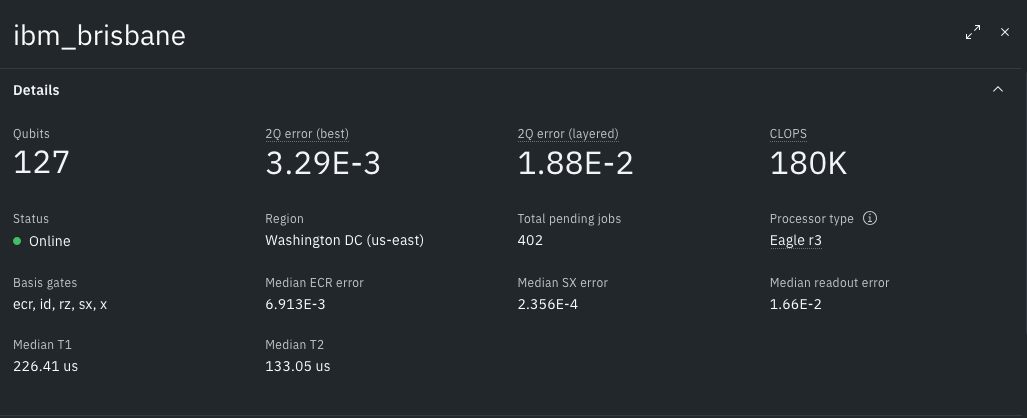

Moreover, one of the interesting things of IBM quantum computers is that you can access to all these features about the systems directly through code.

Let's see how it's done!

<a id="exercise_1"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 1: Find the best qubits </b> 

**Your Goal:** Find the qubits with longer T1, T2, higher gate fidelities, and smaller readout errors

In this first exercise you are asked to provide with the best value of each of the following metrics as well as the qubit, or pair of qubits, that have this value:

- Relaxation time: T1
- Dephasing time: T2
- Readout error
- Single-qubit gate error: 'PauliX' error
- Two-qubits gate error: 'Ecr' error 


<p><i>Note: The ECR gate is the two-qubit gate specific to this backend and may differ on other quantum devices, which might have CZ or CNOT gates.</i></p>


</div>

In [8]:
service = QiskitRuntimeService()
# We define a specific backend
brisbane_backend = service.backend("ibm_brisbane")
# We obtain the system properties, number of qubits and coupling map
properties = brisbane_backend.properties()
num_qubits = brisbane_backend.num_qubits
coupling_map = brisbane_backend.coupling_map
# We define various lists of metrics for all the qubits of the backend
t1, t2, gate_error_x, readout_error, gate_error_ecr = [], [], [], [], []
for i in range(num_qubits):
    t1.append(properties.t1(i))
    t2.append(properties.t2(i))
    gate_error_x.append(properties.gate_error(gate="x", qubits=i))
    readout_error.append(properties.readout_error(i))
for pair in coupling_map:
    gate_error_ecr.append(properties.gate_error(gate="ecr", qubits=pair))



# ---- TODO : Task 1 ---
# Obtain the best value and the index or indices of the qubits of the following metrics:

# Qubit with maximum T1
index_t1_max, max_t1 = max(enumerate(t1), key=lambda x: x[1])

# Qubit with maximum T2
index_t2_max, max_t2 = max(enumerate(t2), key=lambda x: x[1])

# Qubit with minimum X-gate error
index_min_x_error, min_x_error = min(enumerate(gate_error_x), key=lambda x: x[1])

# Qubit with minimum readout error
index_min_readout, min_readout = min(enumerate(readout_error), key=lambda x: x[1])

# Coupling pair with minimum ECR error
min_ecr_pair, min_ecr_error = min(
    zip(coupling_map, gate_error_ecr),
    key=lambda pair_err: pair_err[1]
)
# --- End of TODO ---

solutions = [
    [index_t1_max, max_t1],
    [index_t2_max, max_t2],
    [index_min_x_error, min_x_error],
    [index_min_readout, min_readout],
    [min_ecr_pair, min_ecr_error],
]

In [9]:
# Submit your answer using following code

grade_lab2_ex1(solutions, brisbane_backend)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


Good job! You've learnt how to access the device properties and search for specific characteristics among them. Perhaps at this point you might be wondering whether we cannot just look for the qubits with the best metrics. Well, it is not that easy. 

If you print the indices of the qubits you've obtained, you can see that they aren't clustered in a specific region of the device. Instead, they're spread out across different areas. This highlights a key challenge: a qubit with long relaxation time might also have a large single-qubit gate error, or vice versa. These trade-offs mean that choosing qubits based only on one metric may not lead to optimal performance for certain quantum algorithms. Furthermore, one also needs to take into account that not all the qubits are connected, as it is shown in the coupling map. All of this make the task of chossing the specific layout of qubits an intrincate, but fascinating, challenge. Fortunately for us, in Qiskit there's a dedicated tool designed to handle this problem: **the transpiler**. 

But don't rush, we'll explore that in detail in a later section.

# 2. The problem: Max-cut <a id="max-cut"></a>

The maximum cut ([Max-cut](https://en.wikipedia.org/wiki/Maximum_cut)) problem is a graph problem that lies in the category of [NP-hard](https://en.wikipedia.org/wiki/NP-hardnes), which means there not exists any algorithm that can solve it in polynomial-time. Max-cut is an optimization problem with a wide range of applications including clustering, network science, statistical physics and machine learning. The goal of this problem is to divide the nodes of a graph into two sets using a single cut, in such a way that the number of edges traversed by this cut is maximized. 
Let's visualize it with one example. 

In the picture below you see the max-cut solution of a 5 nodes problem that exemplifies how the graph is divided maximizing the number of edges cut. Another way to view this problem is to consider that finding the maximum cut in a graph means identifying a way to divide the nodes into two groups such that the number of edges connecting nodes from different groups is as large as possible.

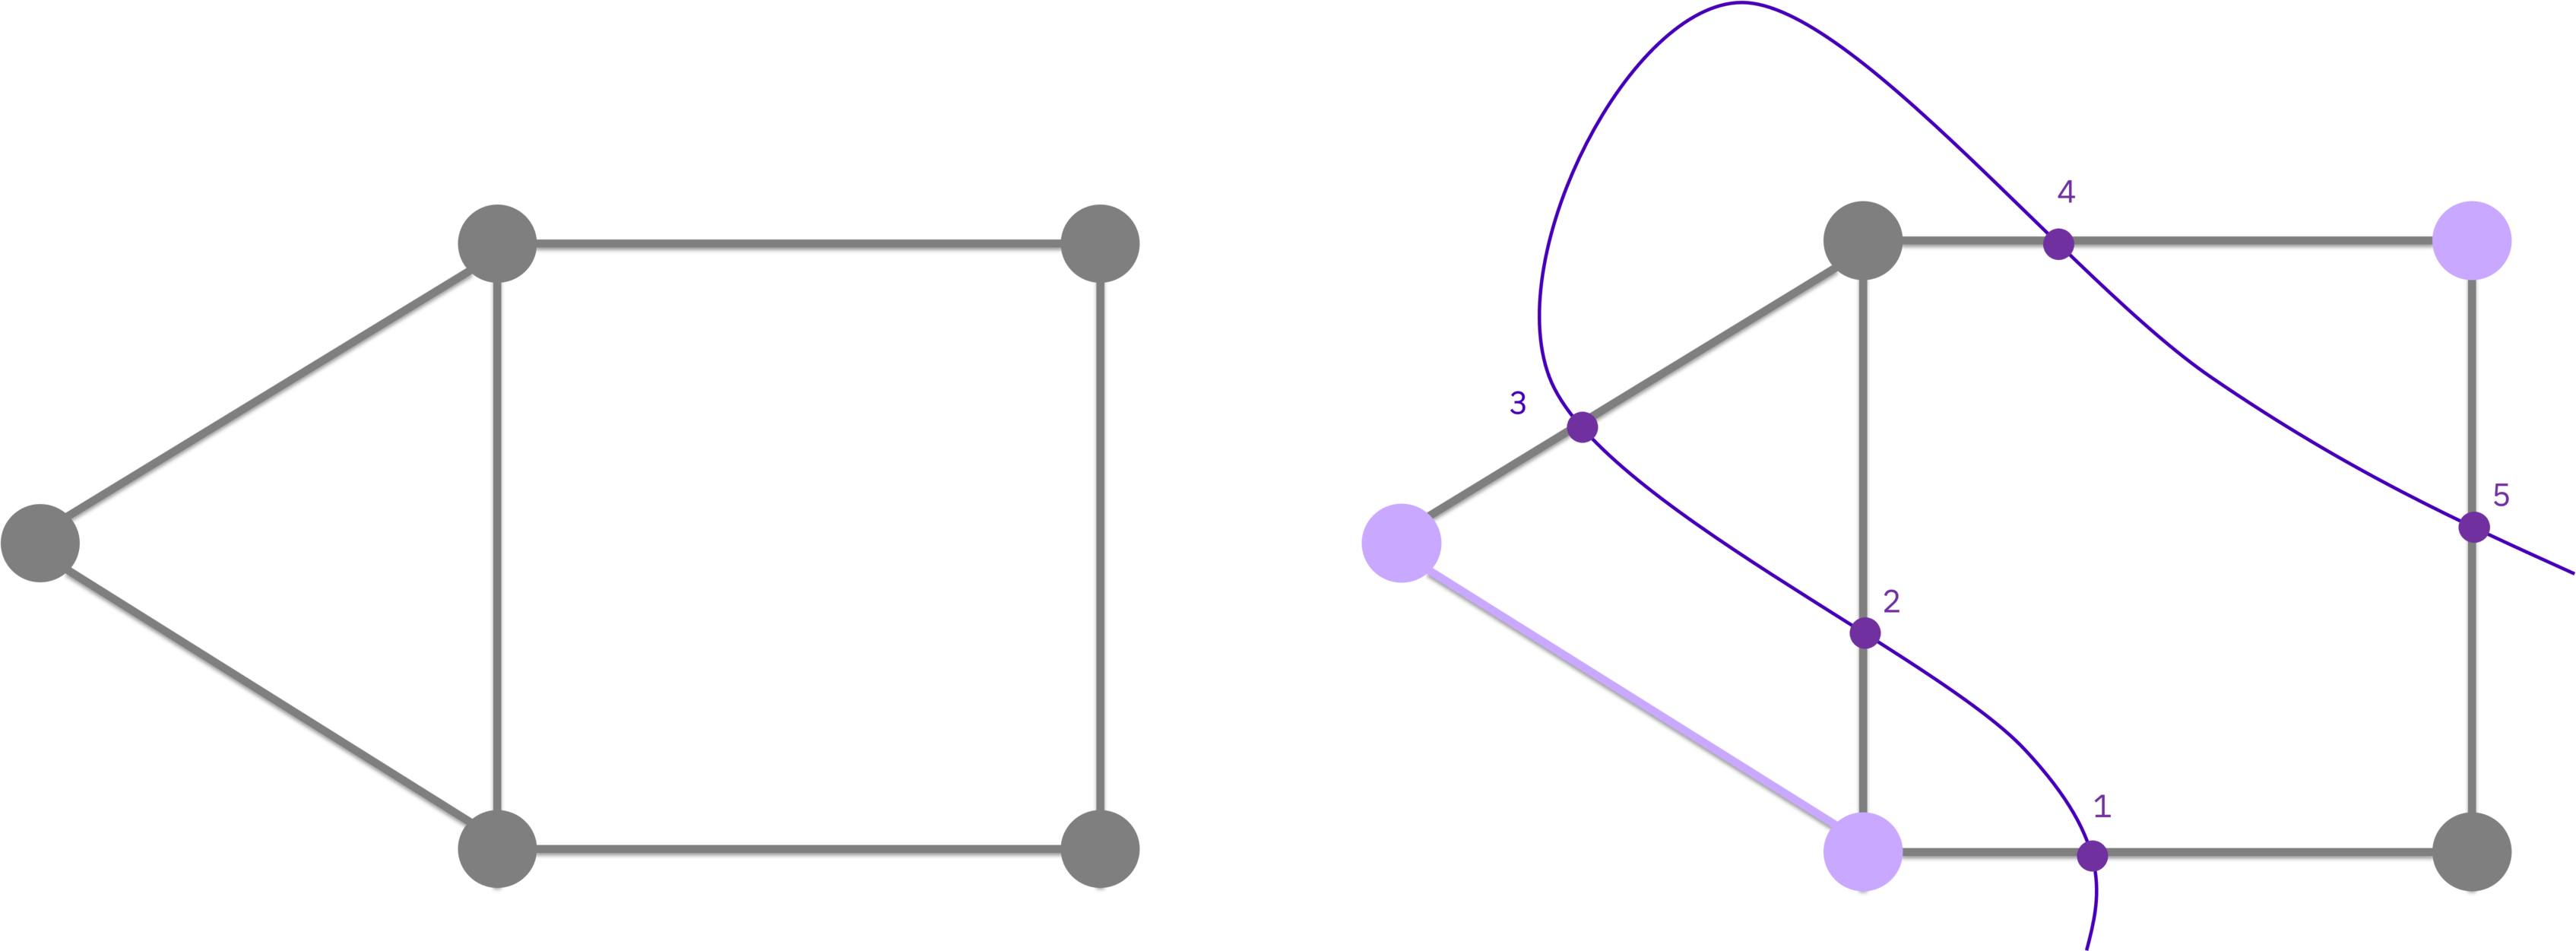

In this lab, we will solve a Max-Cut problem using a quantum algorithm. We'll also study how the quantum noise affects our solution and discuss strategies to reduce its impact, ensuring we can still obtain accurate results despite the noise.

## 2.1 The problem: Define the graph <a id="the-graph"></a>

Now that we have a little bit of context of the Max-cut problem, let's choose a specific graph for which we want to find the maximum cut. In particular, we will choose the graph of the coupling map of a hypothetical quantum computer with all to all connectivity $^*$.

$^*$ *Note that actually the last qubit is not connected to the first one to explicitly break the symmetry of the problem and reduce the number of solutions.*

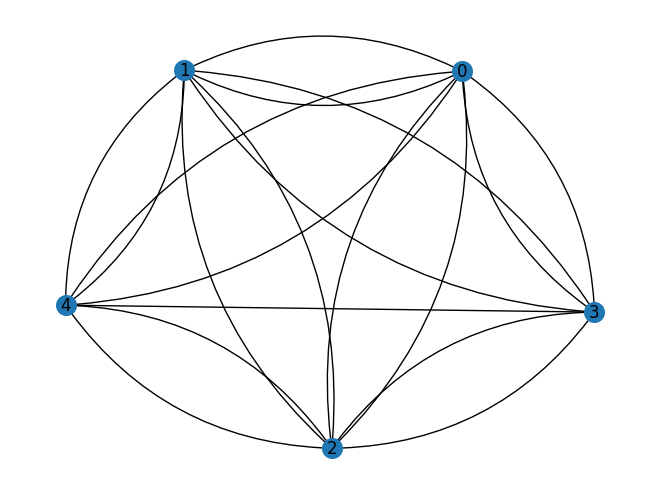

In [10]:
# We define the seed
seed = 43
# We define the number of nodes:
n = 5
# We define the graph
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
generic_backend = GenericBackendV2(n, seed=seed)
weights = 1
# We make it explicitly asymmetrical to have a smaller set of solutions
graph.add_edges_from([(edge[0], edge[1], weights) for edge in generic_backend.coupling_map][:-1])
draw_graph(graph, node_size=200, with_labels=True, width=1)

## 2.2 The mapping: a graph into a quantum computer <a id="the-mapping"></a>

To solve this graph problem using a quantum computer we must first translate it into a language that the quantum computer understands. There are different ways to do that, but one of the most common approaches is using one of the quantum mechanics favourite mathematical objects: **Hamiltonians**.

As explained in detail in this [tutorial](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm), any graph problem can be transformed into a spin Hamiltonian problem using an appropriate mapping. The approach typically involves two main steps: 

1. Reformulate the graph as a Quadratic Unconstrained Binary Optimization (QUBO) problem.
2. Rewrite the QUBO problem as a Hamiltonian whose ground state corresponds to the solution of the original problem.

Sounds easy, right? Well, it better be, because that's exactly what the next exercise is all about!

<a id="exercise_2"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 2: From Graph to Hamiltonian </b> 

**Your Goal:** Map the graph to a Hamiltonian.

In this second exercise you must find the way of mapping the graph problem you are given to a Hamiltonian using the identity and Pauli gates.




</div>

<div class="alert alert-info">
<details>
    <summary> <b>Hint</b> 💡: (Click to expand)</summary>
    The intuition of how to build this Hamiltonian consists of considering a Hilbert space of size n x n in which we add as many terms as edges in the graph, in which the nodes connected by each edge are represented by Pauli-Z matrices whereas the rest of the nodes are represented by the identity. 
</details>
</div>

In [11]:
def graph_to_Pauli(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list."""
    pauli_list = []
    
    # ---- TODO : Task 2 ---
    n = graph.num_nodes()
    for u, v in graph.edge_list():
        paulis = ["I"] * n
        paulis[u], paulis[v] = "Z", "Z"
        weight = graph.get_edge_data(u, v)
        # Qiskit expects qubit-0 as the rightmost character
        pauli_list.append(("".join(paulis)[::-1], weight))
    # --- End of TODO ---

    return pauli_list


max_cut_paulis = graph_to_Pauli(graph)
cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIIZZ', 'IIZIZ', 'IIZIZ', 'IZIIZ', 'IZIIZ', 'ZIIIZ', 'ZIIIZ', 'IIZZI', 'IIZZI', 'IZIZI', 'IZIZI', 'ZIIZI', 'ZIIZI', 'IZZII', 'IZZII', 'ZIZII', 'ZIZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j])


In [12]:
# Submit your answer using following code

grade_lab2_ex2(cost_hamiltonian, graph)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


# 2.3 QAOA solution <a id="qaoa-solution"></a>

QUBO problems are a class of combinatorial optimization problems that can be addressed using different methods. In our case, we've reformulated the Max-cut problem as an Ising Hamiltonian, which opens the door to use quantum computing to solve it.
One possible strategy is to search for the ground state of the Ising Hamiltonian, since this lowest-energy state encodes the solution to the original QUBO problem. Therefore, we have mapped a classical combinatorial problem into a ground state search problem.

In that regard, several quantum algorithms can be employed to solve this problem. One of the most widely used and versatile methods is the Quantum Approximate Optimization Algorithm ([QAOA](https://en.wikipedia.org/wiki/Quantum_optimization_algorithms)). QAOA is known for its adaptability, relatively shallow circuit depth, and strong performance across a range of optimization tasks.

If you want a full description on QAOA we recommend you this [tutorial](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm). Here, we will briefly comment on the main idea behind it. QAOA is a variational quantum algorithm inspired by the adiabatic theorem, which states that a quantum system remains in its ground state if it evolves slowly enough. QAOA mimics this by starting in the ground state of a known Hamiltonian (the mixer) and evolving toward the ground state of a Hamiltonian that encodes our problem (the cost). This is done through alternating layers of the two Hamiltonians, with each step controlled by tuneable parameters that guide the system toward the optimal solution.

After this little explanation of the theory, let's get our hands dirty and jump to the code to see how we can use Qiskit to implement QAOA and solve our Max-cut problem!

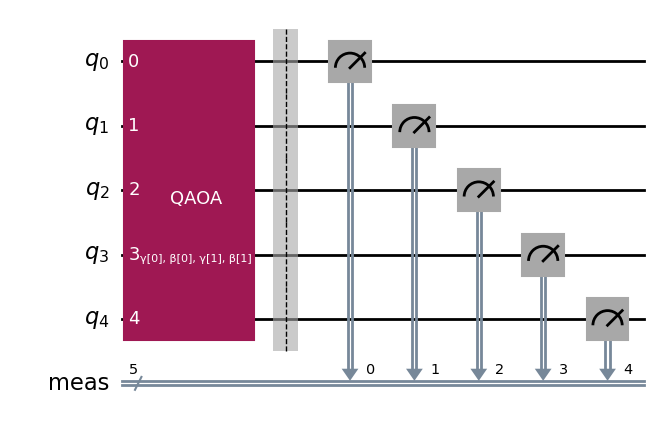

In [13]:
layers = 2
qaoa_circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=layers)
qaoa_circuit.measure_all()
qaoa_circuit.draw("mpl")

After we define the QAOA circuit we must pass it to the Pass Manager to transpile it into the native gates of the backend.

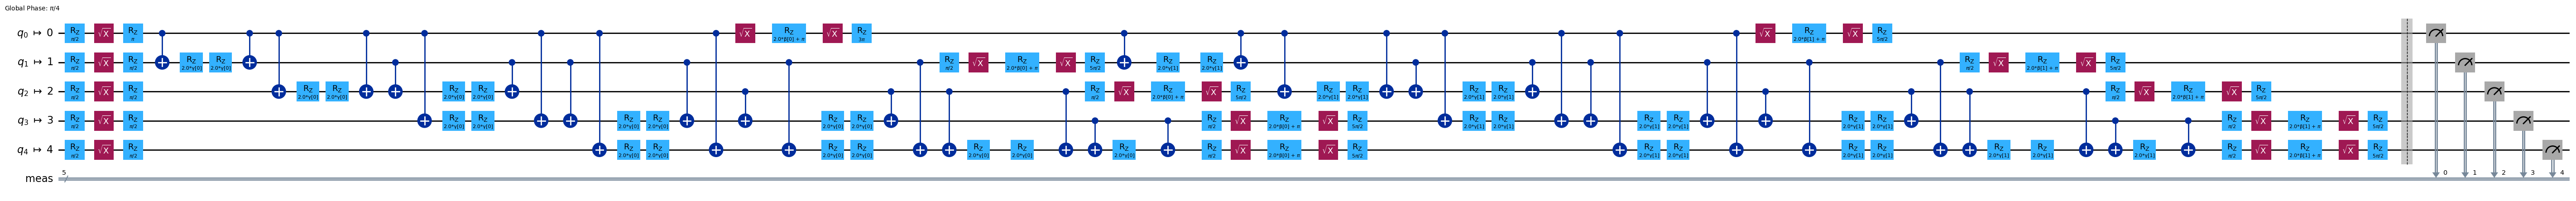

In [14]:
# Create pass manager for transpilation

pm = generate_preset_pass_manager(
    optimization_level=3, backend=generic_backend, seed_transpiler=seed
)

qaoa_circuit_transpiled = pm.run(qaoa_circuit)
qaoa_circuit_transpiled.draw("mpl", fold=False, idle_wires=False)

We define now the initial parameters of our QAOA model.


In [15]:
init_params = np.zeros(2 * layers)

We define and execute an optimization method using the library `scipy`.

In [16]:
objective_func_vals = []


def cost_func_estimator(
    params: list, ansatz: QuantumCircuit, isa_hamiltonian: SparsePauliOp, estimator: Estimator
) -> float:
    """Compute the cost function value using a parameterized ansatz and an estimator for a given Hamiltonian."""
    if isa_hamiltonian.num_qubits != ansatz.num_qubits:
        isa_hamiltonian = isa_hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)
    return cost


def train_qaoa(
    params: list,
    circuit: QuantumCircuit,
    hamiltonian: SparsePauliOp,
    backend: QiskitRuntimeService.backend,
) -> tuple:
    """Optimize QAOA parameters using COBYLA and an estimator on a given backend."""
    with Session(backend=backend) as session:
        options = {"simulator": {"seed_simulator": seed}}
        estimator = Estimator(mode=session, options=options)
        estimator.options.default_shots = 100000

        result = minimize(
            cost_func_estimator,
            params,
            args=(circuit, hamiltonian, estimator),
            method="COBYLA",
            options={"maxiter": 200, "rhobeg": 1, "catol": 1e-3, "tol": 0.0001},
        )
    print(result)
    return result, objective_func_vals


result_qaoa, objective_func_vals = train_qaoa(
    init_params, qaoa_circuit_transpiled, cost_hamiltonian, generic_backend
)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.709212907870921
       x: [ 9.738e-01  9.892e-01 -5.693e-01  1.030e+00]
    nfev: 56
   maxcv: 0.0


After the optimization routine is executed, we can see how the cost function evolves with the number of iterations to check how the algorithm has converged

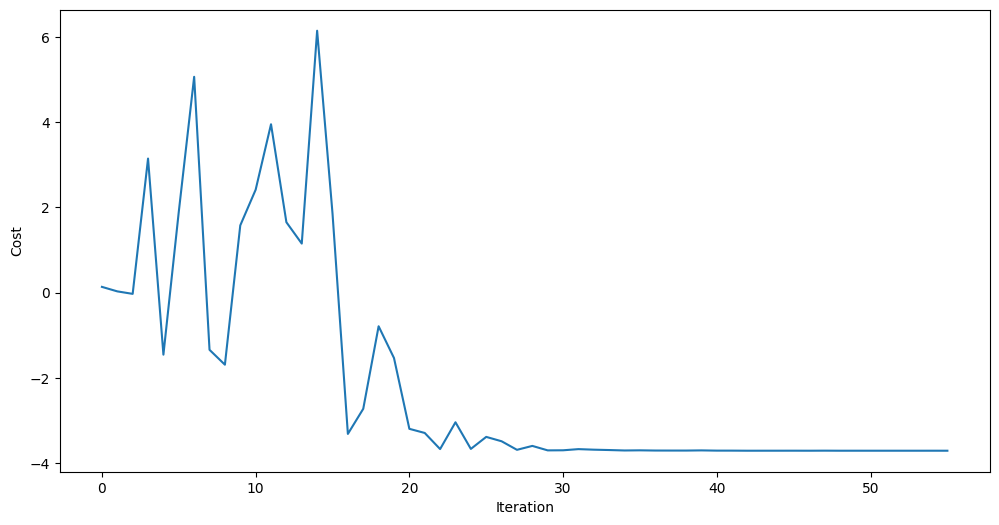

In [17]:

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Nice! As you can see, our circuit has trained quite well, converging to a value that should correspond to the minimum energy of the cost Hamiltonian representing our problem. But are we done yet? How can we be sure that this really is the minimum energy? And equally important, although we might have found the minimum energy, what ground state does it correspond to? Or in other words, what is the actual solution to the Max-Cut problem?

# 2.4 Checking our solution <a id="checking"></a>

After training our QAOA circuit using the Estimator primitive to obtain the ground energy of the cost Hamiltonian, we can obtain the ground state by using the Sampler primitive running the circuit with the optimized parameters of the QAOA.

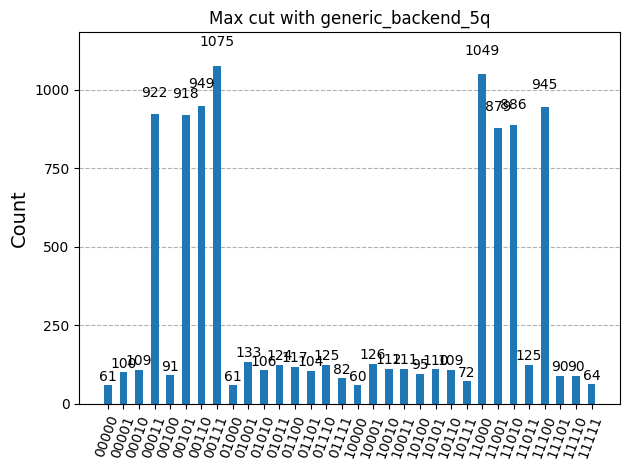

In [18]:
# Get the optimized parameters from the result
opt_params = result_qaoa.x
SHOTS = 10000


def sample_qaoa(opt_params, circuit, backend):

    # Submit the circuit to Sampler
    options = {"simulator": {"seed_simulator": seed}}
    sampler = Sampler(mode=backend, options=options)
    job = sampler.run([(circuit, opt_params)], shots=SHOTS)
    results_sampler = job.result()
    counts_list = results_sampler[0].data.meas.get_counts()
    display(plot_histogram(counts_list, title=f"Max cut with {backend.name}"))

    return counts_list


counts_list = sample_qaoa(opt_params, qaoa_circuit_transpiled, generic_backend)

So, it looks we have 8 different states with significant higher probabilities than the rest, which suggests there might be 8 different ground states. But how can we check that? Luckily for us, this Max-cut problem it's not so big in size, so it can still be solved analytically to help us discern if our solution is a good or bad approximation. Let's take a look!

The way of solving this Max-cut problem analytically is by diagonalizing the cost Hamiltonian. Note that this can be done because the size of the problem is not too large, however the complexity of this problem scales exponentially with the number of nodes (qubits), so the problem becomes intractable for a large number of nodes.

In [19]:
eigenvalues, eigenvectors = np.linalg.eig(cost_hamiltonian)
ground_energy = min(eigenvalues).real
num_solutions = eigenvalues.tolist().count(ground_energy)
index_solutions = np.where(eigenvalues == ground_energy)[0].tolist()
print(f"The ground energy of the Hamiltonian is {ground_energy}")
print(f"The number of solutions of the problem is {num_solutions}")
print(f"The list of the solutions based on their index is {index_solutions}")

The ground energy of the Hamiltonian is -5.0
The number of solutions of the problem is 8
The list of the solutions based on their index is [3, 5, 6, 7, 24, 25, 26, 28]


Great, we obtained 8 solutions as well, so let us now do some postprocessing to check if the 8 possible solutions match with ours.

In [20]:
def decimal_to_binary(decimal_list, n):
    return [bin(num)[2:].zfill(n) for num in decimal_list]


# Convert the solutions to quantum states
states_solutions = decimal_to_binary(index_solutions, n)
# Sort the dictionary items by their counts in descending order
sorted_states = sorted(counts_list.items(), key=lambda item: item[1], reverse=True)
# Take the top 'num_solutions' entries
top_states = sorted_states[:num_solutions]
# Extract only the states keys from the top entries
qaoa_ground_states = sorted([state for state, count in top_states])
print(f"The analytical solutions for the Max-cut problem are: {states_solutions}")
print(f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states}")

The analytical solutions for the Max-cut problem are: ['00011', '00101', '00110', '00111', '11000', '11001', '11010', '11100']
The QAOA ground states solutions for the Max-cut are: ['00011', '00101', '00110', '00111', '11000', '11001', '11010', '11100']


Hurray! We've successfully found the right solution of the Max-cut problem using QAOA!

However, it's important to note that these results were obtained using ideal quantum simulators, which do not account for the noise and imperfections present in real quantum hardware. In the next section, we'll explore how QAOA performs when executed on a noisy quantum simulator, giving us a practical view on how noise affect our quantum algorithms.

# 3. Noisy quantum simulator <a id="noisy-simulator"></a>

In this section, we'll run the QAOA algorithm on noisy quantum simulators. These simulators are useful tools that aim to mimic the behaviour and noise of real quantum processors. They allow us to test and evaluate how our quantum algorithms could perform on actual quantum hardware, without consuming valuable quantum resources. Additionally, noisy simulators often run faster since they are executed locally on your machine, avoiding the potential delays and queues associated with cloud-based quantum devices.

However, before we proceed, an important question arises. Which quantum device should I use? This is a key question that is sometimes overlooked. In the following, we'll explore how to choose the most suitable device (or simulator) for running a specific quantum algorithm.

## 3.1 Choosing the backend <a id="choosing-backend"></a>

As introduced above, here we'll introduce a quantum backend that corresponds to a noisy simulator that mimics the noise of a quantum device.

Let's see which backends are available for you.

In [21]:
real_backends = service.backends()
print(f"The quantum computers available for you are {real_backends}")

The quantum computers available for you are [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_torino')>]


If you are using the free plan, you should have `ibm_brisbane`, `ibm_sherbrooke` and `ibm_torino`. 

We can now create a noisy simulator for each backend you have access and see which gates they have.

<div class="alert alert-block alert-warning">
<b>Backends Availability</b>

Depending on your account, you may have different backends available. Use only 3 backends, if possible `ibm_brisbane`, `ibm_sherbrooke` and `ibm_torino`, but if they are not available to you for some reason feel free to use 3 different ones.

In [22]:
real_backends=[service.backend("ibm_brisbane"),service.backend("ibm_sherbrooke"),service.backend("ibm_torino")]

In [23]:
noisy_fake_backends = []
for backend in real_backends:
    noisy_fake_backends.append(AerSimulator.from_backend(backend, seed_simulator=seed))
print(f"The noisy simulators are {noisy_fake_backends}")

The noisy simulators are [AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['reset', 'sx', 'x', 'id', 'ecr', 'measure']>), AerSimulator('aer_simulator_from(ibm_sherbrooke)'
             noise_model=<NoiseModel on ['reset', 'sx', 'x', 'id', 'ecr', 'measure']>), AerSimulator('aer_simulator_from(ibm_torino)'
             noise_model=<NoiseModel on ['reset', 'sx', 'cz', 'x', 'id', 'measure']>)]


Now we transpile the QAOA circuit to the different backends and do a relatively simple analysis of their potential errors

In the next exercise, you are going to count what is the accumulated total error of applying the different quantum circuits for the different backends. We can do that using `backend.properties()`, `circuit.data` and `backend.configuration()` as they will provide us with the required information to account an estimation of all the different errors introduced by each instruction.

<a id="exercise_3"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 3: Error Counting </b> 

**Your Goal:** Estimate the total error of the quantum circuit. 

In this third exercise you will estimate the total error introduced by all the instructions when executing quantum circuits on different backends.<br> 
In particular, you'll have to account for the errors introduced by:

- Single-qubit gates: Assume all single-qubit gates have the same error, modeled as a 'PauliX' error.
- Two-qubit gates: Depending on the backend, these may include 'cz', 'cx', or 'ecr' gates. You’ll need to identify which gate is used on each backend.
- Readout errors: These contribute a constant error added at the end of the total accumulated error.

Keep in mind that each qubit has different error rates, so you cannot simply count all operations and multiply by average error values from the IBMQ platform. <br>
While this approximation might yield similar results, the goal of this exercise is to teach you how to access detailed backend information and perform a more accurate estimation considering the specific error rates per qubit.

In [24]:
qaoa_transpiled_list = []
errors_and_counts_list = []
for noisy_fake_backend in noisy_fake_backends:
    pm = generate_preset_pass_manager(
        backend=noisy_fake_backend,
        optimization_level=3,
        seed_transpiler=seed,
    )
    circuit = pm.run(qaoa_circuit)
    qaoa_transpiled_list.append(circuit)

    # Define a function that calculates the accumulated total errors of single and two qubit gates and readout
    def accumulated_errors(backend: QiskitRuntimeService.backend, circuit: QuantumCircuit) -> list:
        """Compute the accumulated gate and readout errors for a given circuit on a specific backend."""

        # ---- TODO : Task 3 ---
        # You have to define the following quantities:
        # acc_total_error, acc_two_qubit_error, acc_single_qubit_error, acc_readout_error,single_qubit_gate_count, two_qubit_gate_count
        props = backend.properties()
        n = circuit.num_qubits

        # Precompute error lists for this backend
        gate_error_x_local  = [props.gate_error("x", [i]) for i in range(n)]
        readout_error_local = [props.readout_error(i)    for i in range(n)]
        two_q_errors        = { 
            (gp.qubits[0], gp.qubits[1]): props.gate_error(gp.gate, gp.qubits)
            for gp in props.gates if len(gp.qubits) == 2
        }

        single_qubit_gate_count = 0
        two_qubit_gate_count    = 0
        acc_single_qubit_error  = 0.0
        acc_two_qubit_error     = 0.0
        acc_readout_error       = 0.0

        for inst, qargs, _ in circuit.data:
            op = inst.name.lower()

            # Treat measure as a single-qubit gate + readout
            if op == "measure":
                for q in qargs:
                    idx = circuit.qubits.index(q)
                    # count as a single-qubit gate
                    single_qubit_gate_count += 1
                    acc_single_qubit_error += gate_error_x_local[idx]
                    # then add the readout error
                    acc_readout_error += readout_error_local[idx]
                continue

            # skip barrier/reset
            if op in ("barrier", "reset"):
                continue

            # single-qubit gate
            if len(qargs) == 1:
                single_qubit_gate_count += 1
                idx = circuit.qubits.index(qargs[0])
                acc_single_qubit_error += gate_error_x_local[idx]

            # two-qubit gate
            elif len(qargs) == 2:
                two_qubit_gate_count += 1
                idxs = tuple(circuit.qubits.index(q) for q in qargs)
                # look up the native two-qubit error (cx, cz, or ecr)
                err = two_q_errors.get(idxs) or two_q_errors.get(idxs[::-1], 0.0)
                acc_two_qubit_error += err

        # --- End of TODO ---
        
        acc_total_error = acc_two_qubit_error + acc_single_qubit_error + acc_readout_error
        results = [
            acc_total_error,
            acc_two_qubit_error,
            acc_single_qubit_error,
            acc_readout_error,
            single_qubit_gate_count,
            two_qubit_gate_count,
        ]
        # You can print your results to visualize if they are correct
        print(f"Backend {backend.name}")
        print(f"Accumulated two-qubit error of {two_qubit_gate_count} gates: {acc_two_qubit_error:.3f}")
        print(
            f"Accumulated one-qubit error of {single_qubit_gate_count} gates: {acc_single_qubit_error:.3f}"
        )
        print(f"Accumulated readout error: {sum(readout_error):.3f}")
        print(f"Accumulated total error: {acc_total_error:.3f}\n")

        return results

    errors_and_counts = accumulated_errors(noisy_fake_backend, circuit)
    errors_and_counts_list.append(errors_and_counts)

Backend aer_simulator_from(ibm_brisbane)
Accumulated two-qubit error of 70 gates: 0.323
Accumulated one-qubit error of 457 gates: 0.093
Accumulated readout error: 3.592
Accumulated total error: 0.489

Backend aer_simulator_from(ibm_sherbrooke)
Accumulated two-qubit error of 70 gates: 0.244
Accumulated one-qubit error of 458 gates: 0.083
Accumulated readout error: 3.592
Accumulated total error: 0.435

Backend aer_simulator_from(ibm_torino)
Accumulated two-qubit error of 70 gates: 0.141
Accumulated one-qubit error of 255 gates: 0.066
Accumulated readout error: 3.592
Accumulated total error: 0.319



Let's plot the results.

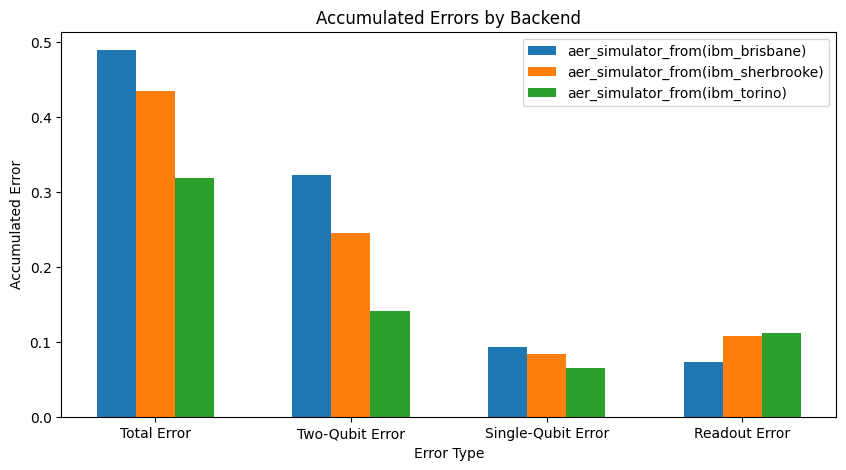

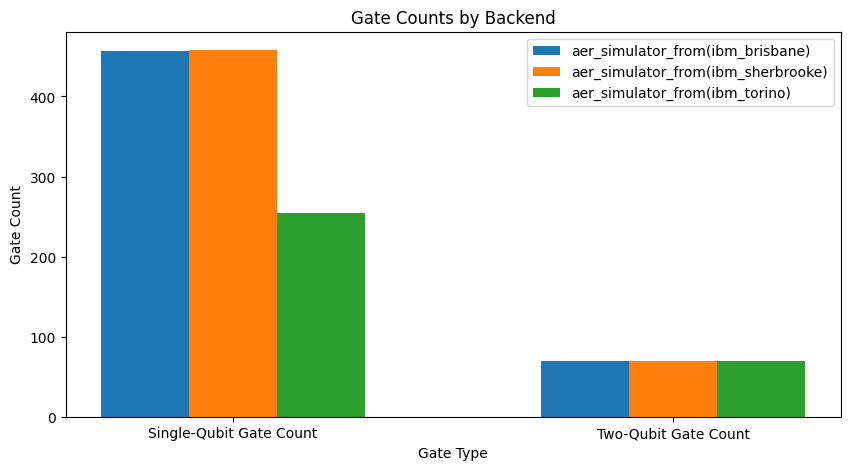

In [25]:
plot_backend_errors_and_counts(noisy_fake_backends, errors_and_counts_list)

In [26]:
# Submit your answer using following code

grade_lab2_ex3(errors_and_counts_list, noisy_fake_backends, qaoa_transpiled_list)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


We have seen that `ibm_torino` has a smaller accumulated error than the other noisy backends. Let's put these results into practice by running the whole QAOA algorithm with the different backends!


<div class="alert alert-block alert-warning">
<b>Warning: 20 minutes needed</b>

When running the code below it will take up to 20 minutes (depending on your computer) to execute and will block this notebook for this time. 

</div>

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.6545634543654564
       x: [ 9.251e-01  1.191e+00  1.982e-02  9.323e-01]
    nfev: 56
   maxcv: 0.0


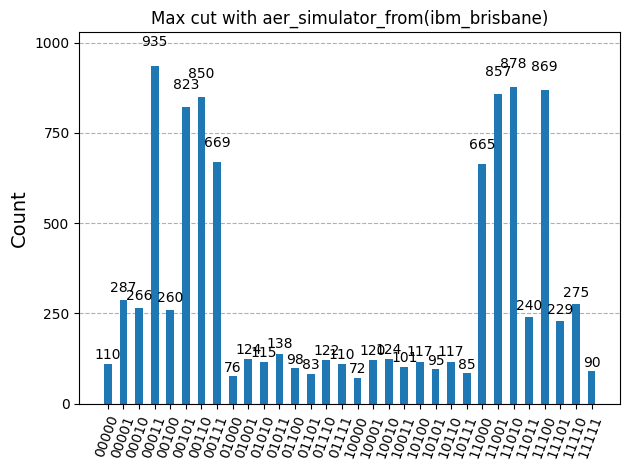

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.933520664793352
       x: [ 1.524e-01  1.055e+00  1.018e+00 -8.167e-02]
    nfev: 65
   maxcv: 0.0


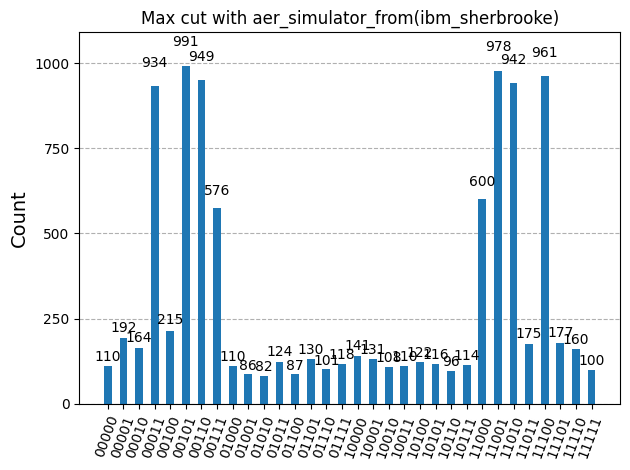

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [27]:
opt_params_list = []
counts_list_backends = []
for noisy_fake_backend, circuit in zip(noisy_fake_backends, qaoa_transpiled_list):
    result_backend, _ = train_qaoa(init_params, circuit, cost_hamiltonian, noisy_fake_backend)
    opt_params = result_backend.x
    opt_params_list.append(opt_params)
    counts_list_backend = sample_qaoa(opt_params, circuit, noisy_fake_backend)
    counts_list_backends.append(counts_list_backend)

So, it looks like the three backends give the correct result. However, it looks like the `ibm_torino` backend presents lower noise levels, as the probabilities of measuring a state that is not a solution are lower.

At this point, we can define a metric based on the probability of measuring a correct solution to compare backend performance. Since all three backends have predicted the same 8 solutions as the most probable outcomes, this metric provides a useful way to identify which backend is more reliable in practice.

In [ ]:
for noisy_fake_backend, counts_list_backend in zip(noisy_fake_backends, counts_list_backends):
    solutions_counts = [counts_list_backend[key] for key in states_solutions]
    print(
        f"The probability of measuring a solution for {noisy_fake_backend.name} is {float(sum(solutions_counts)/SHOTS)}"
    )

The probability of measuring a solution for aer_simulator_from(ibm_brisbane) is 0.6546
The probability of measuring a solution for aer_simulator_from(ibm_sherbrooke) is 0.6656
The probability of measuring a solution for aer_simulator_from(ibm_torino) is 0.7019


As expected, the `ibm_torino` provides us with the highest probability of measuring a solution. This confirms that our earlier error estimation analysis was correct in predicting which backend would execute the algorithm with minimum errors. To further understand the impact of noise, we can also compare these probabilities to that of the GenericBackend, which simulates an ideal, noise-free scenario.

In [ ]:
solutions_counts_noiseless = [counts_list[key] for key in states_solutions]
print(
    f"The probability of measuring a solution for {generic_backend.name} is {float(sum(solutions_counts_noiseless)/SHOTS)}"
)

The probability of measuring a solution for generic_backend_5q is 0.7623


The probability of measuring a correct solution on the noise-free GenericBackend is, as expected, higher than on the noisy backends. However, the difference is not that big. This highlights an important point. Even with current noisy quantum computers, with careful and smart circuit design and using the right tools, we can still solve many problems with a good degree of accuracy!

# 3.2 Estimating errors using NEAT <a id="neat"></a>

The error estimation we have done above is a nice approximation to get a rough idea of how noisy a device is going to be. In that regard Qiskit offers us another alternative, the Noisy Estimator Analyzer Tool (NEAT). NEAT is a function designed to help users understand and predict the performance of quantum estimation tasks, particularly when using the Estimator primitive. It leverages the qiskit-aer simulator to perform both ideal (noiseless) and noisy simulations of quantum circuits. 

A key feature of NEAT is its ability to simulate Clifford circuits efficiently. For non-Clifford circuits, NEAT can automatically convert them to their nearest Clifford equivalents which approximate their quantum state. This makes NEAT especially useful for performing a noise analysis of our quantum circuits before running them on real quantum hardware. However, this approximation introduces limitations, since Clifford equivalents do not perfectly replicate the behaviour of non-Clifford circuits, the simulation may lose accuracy in certain cases.

From a practical point of view, one way to use NEAT is to simulate a quantum circuit in a noisy and noiseless scenario measuring an observable whose expectation value is exactly 1 in the ideal (noiseless) case. In this setup, any deviation from 1 in the noisy simulation directly reflects the impact of noise on the circuit. An easy way to ensure that the observable meets the requirements is choosing:
$$
\hat{O}=|\psi\rangle\langle \psi|, \quad \textrm{since} \quad \langle \psi |\hat{O}|\psi \rangle=1, 
$$
where $|\psi\rangle$ is the quantum state generated by the circuit we want to simulate. 

Let's apply NEAT to our different noisy backends to see how they perform!

In [28]:
results = []
for backend, opt_params in zip(noisy_fake_backends, opt_params_list):
    print(f"\nRunning on backend: {backend.name}")

    # Prepare the QAOA circuit with optimized parameters
    qaoa_neat = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=layers)
    qc = qaoa_neat.assign_parameters(opt_params)

    # Transpile the circuit
    qc_transpiled = transpile(
        qc,
        optimization_level=3,
        basis_gates=backend.configuration().basis_gates[:n],
        seed_transpiler=seed,
    )
    # Use cost Hamiltonian as observable for Cliffordization
    obs = cost_hamiltonian
    analyzer = Neat(backend)
    clifford_pub = analyzer.to_clifford([(qc_transpiled, obs)])[0]

    # Construct observable from Clifford circuit
    state_clifford = Statevector.from_instruction(clifford_pub.circuit)
    obs_clifford = SparsePauliOp.from_operator(Operator(DensityMatrix(state_clifford).data))

    # Apply layout
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=seed)
    isa_qc = pm.run(clifford_pub.circuit)
    isa_obs = obs_clifford.apply_layout(isa_qc.layout)

    # Prepare pubs and simulate
    pubs = [(isa_qc, isa_obs)]
    result_noiseless = (
        analyzer.ideal_sim(pubs, cliffordize=True, seed_simulator=seed)._pub_results[0].vals
    )
    noisy_results = (
        analyzer.noisy_sim(pubs, cliffordize=True, seed_simulator=seed)._pub_results[0].vals
    )

    # Store and print results
    results.append({"backend": backend.name, "noiseless": result_noiseless, "noisy": noisy_results})
    print(f"Ideal results on {backend.name}:\n{result_noiseless:.3f}")
    print(f"Noisy results on {backend.name}:\n{noisy_results:.3f}")


Running on backend: aer_simulator_from(ibm_brisbane)
Ideal results on aer_simulator_from(ibm_brisbane):
1.000
Noisy results on aer_simulator_from(ibm_brisbane):
0.782

Running on backend: aer_simulator_from(ibm_sherbrooke)
Ideal results on aer_simulator_from(ibm_sherbrooke):
1.000
Noisy results on aer_simulator_from(ibm_sherbrooke):
0.659


Using the Neat tool, we can observe how the expectation value in a noisy simulation deviates from the ideal value of 1 in a way that is in agreement with the noise analysis performed in Section 3.1. 

However, as mentioned before, we should be aware that here we are analysing Cliffordized versions of the quantum circuits, which means that some gates have been transformed to ensure the circuit belongs to the Clifford group. As a result, while the transformed circuit is similar, it does not produce exactly the same quantum state. This means that Neat provides a useful approximation of how much noise a circuit might accumulate on a given backend, but it doesn't offer exact predictions or guarantees. So, keep that in mind!

# 4. Transpiler <a id="transpiler"></a>

The transpiler is one of the most important and useful tools in the context of execution of quantum circuits on real quantum hardware. It serves as a bridge between the abstract, idealized version of a quantum circuit and the physical implementation on the actual quantum device. When you design a circuit, you typically use virtual qubits and ideal gates without considering the hardware's specific limitations. The transpiler translates this high-level circuit into a version that can be implemented on a real quantum computer, using only the physical qubits gate operations available on the device.

For example, suppose your circuit includes a CNOT gate between virtual qubits 0 and 1. On a real device, these two qubits might not be directly connected. In such cases, the transpiler inserts a series of SWAP gates to move the quantum states to physically adjacent qubits, enabling the CNOT operation. Alternatively, the transpiler might find a more efficient qubit mapping, such that virtual qubits 0 and 1 are reassigned to physical qubits that are directly connected, for example qubits 3 and 4, hence avoiding the need for additional SWAP gates.

Up to now we have been using the transpiler implicitly when executing the pass manager in `generate_preset_pass_manager`. However now we will put the focus on it, trying to understand it better and to leverage it at its fullest for our better design of quantum circuits.

# 4.1 Minimizing the two-qubit gates <a id="min-two-qubit"></a>

One of the most important tasks of a quantum transpiler is to determine an optimal qubit layout for executing a quantum circuit. This involves finding the best mapping between the circuit's virtual qubits and the device's physical qubits. To do so, there are a few things to take into consideration. 

First, the transpiler must check for all the two-qubit gates in the circuit and ensure that the selected physical qubits are connected in a way that, enable these operations. This reduces the necessity of using additional SWAP gates. This requires inspecting the coupling map, which shows how physical qubits are connected.

The first thing we will do is to perform a transpilation of the quantum circuit to a layout in the quantum computer in a way that minimizes the number of two-qubit gates, since that will be the main source of error.

In particular, we will consider the backend `ibm_brisbane` backend, where, as shown in Section 3.1, two-qubit gate errors account for the majority of the total accumulated error.

In [82]:
# We select the `ibm_brisbane` backend
num_backend = 0
noisy_fake_backend = noisy_fake_backends[num_backend]

pm = generate_preset_pass_manager(
    backend=noisy_fake_backend,
    optimization_level=3,
    seed_transpiler=seed,
    layout_method="sabre",
)
circuit_transpiled = pm.run(qaoa_circuit)


def two_qubit_gate_errors_per_circuit_layout(
    circuit: QuantumCircuit, backend: QiskitRuntimeService.backend
) -> tuple:
    """Calculate accumulated two-qubit gate errors and related metrics for a given circuit layout."""
    pair_list = []
    error_pair_list = []
    error_acc_pair_list = []
    two_qubit_gate_count = 0
    properties = backend.properties()
    if "ecr" in (backend.configuration().basis_gates):
        two_qubit_gate = "ecr"
    elif "cz" in (backend.configuration().basis_gates):
        two_qubit_gate = "cz"
    for instruction in circuit.data:
        if instruction.operation.num_qubits == 2:
            two_qubit_gate_count += 1
            pair = [instruction.qubits[0]._index, instruction.qubits[1]._index]
            error_pair = properties.gate_error(gate=two_qubit_gate, qubits=pair)
            if pair not in (pair_list):
                pair_list.append(pair)
                error_pair_list.append(error_pair)
                error_acc_pair_list.append(error_pair)
            else:
                pos = pair_list.index(pair)
                error_acc_pair_list[pos] += error_pair

    acc_two_qubit_error = sum(error_acc_pair_list)
    return (
        acc_two_qubit_error,
        two_qubit_gate_count,
        pair_list,
        error_pair_list,
        error_acc_pair_list,
    )


(
    acc_two_qubit_error,
    two_qubit_gate_count,
    pair_list,
    error_pair_list,
    error_acc_pair_list,
) = two_qubit_gate_errors_per_circuit_layout(circuit_transpiled, noisy_fake_backend)
two_qubit_ops_list = [int(a / b) for a, b in zip(error_acc_pair_list, error_pair_list)]
# We print the results
print(f"The pairs of qubits that need to perform two-qubit operations are:\n {pair_list}")
print(f"The errors introduced by each of the two-qubit operations are:\n {[round(err,3) for err in error_pair_list]}")
print(
    f"The accumulated errors introduced by each of the two-qubit operations are:\n {[round(err,3) for err in error_acc_pair_list]}"
)
print(f"The repetitions of each one of the two-qubit operations is:\n {two_qubit_ops_list}")
print(f"The number of two-qubit operations in total:\n {two_qubit_gate_count}")
print(f"The total accumulated error by two-qubit operations is:\n {acc_two_qubit_error:.3f}")

The pairs of qubits that need to perform two-qubit operations are:
 [[62, 72], [81, 72], [62, 61], [62, 63]]
The errors introduced by each of the two-qubit operations are:
 [0.006, 0.006, 0.006, 0.007]
The accumulated errors introduced by each of the two-qubit operations are:
 [0.177, 0.073, 0.081, 0.099]
The repetitions of each one of the two-qubit operations is:
 [29, 13, 13, 15]
The number of two-qubit operations in total:
 70
The total accumulated error by two-qubit operations is:
 0.430


# 4.2 Find the optimal layout <a id="opt-layout"></a>

Next, the transpiler must choose the "best" physical qubits that fulfill the connectivity constraints. However, defining “best qubits” in this context is a challenging task, as it depends on multiple hardware-specific metrics such as coherence times ($T_1$, $T_2$), single-qubit gate error rates, readout errors, and two-qubit gate error rates. Optimizing across all these metrics at the same time is not straightforward and it often involves trade-offs.

In this exercise, we simplify the problem by focusing on two criteria: 
1. The selected qubits must satisfy the required connectivity gave by the transpiler
2. We choose the qubits with the lowest two-qubit gate error rates

As discussed in Section 3.1, two-qubit gate errors are typically the predominant source of noise in many quantum devices.

Now the exercise is to look for a different qubit configuration (layout) that gives you a smaller total accumulated error accounting just for the two-qubit gates. However, this may be too easy, and since we're approaching the end of the lab, let's increase the difficulty and look for all the possible layouts that offer a smaller total accumulated error of two qubit gates operations.

<a id="exercise_4"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 4: Good Mapping </b> 

**Your Goal:** Find all the good qubit layouts. 

In this fourth exercise you are asked to find ALL the possible qubit layouts that have a smaller two-qubit gate accumulated error than the layout transpilation of above, whose value is stored in the variable `acc_two_qubit_error`. This problem can be reformulated as a graph problem where you need to find ALL the paths in the graph below whose total edge weights sum to less than the specified threshold.

Building this graph will help you visualize the possible configurations and will also serve to find all the layouts that fulfill the desired conditions.

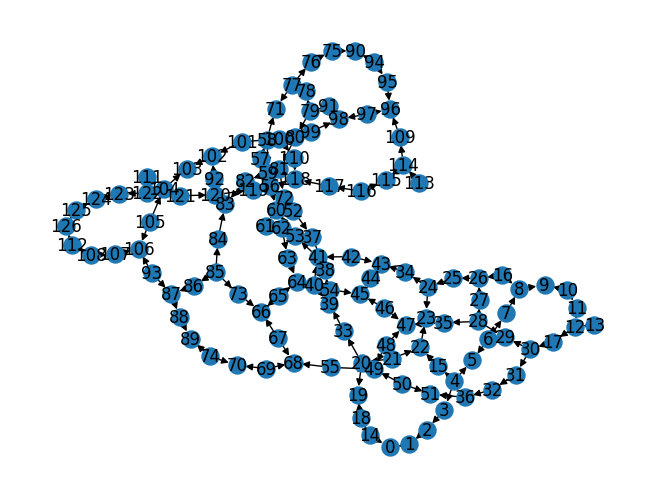

In [83]:
# We build a graph with the connectivity constraints of our backend that includes the two-qubit gate errors as weights in the edges
graph = rx.PyDiGraph()
graph.add_nodes_from(np.arange(0, noisy_fake_backend.num_qubits, 1))
two_qubit_gate = "ecr"
graph.add_edges_from(
    [
        (
            edge[0],
            edge[1],
            noisy_fake_backend.properties().gate_error(gate=two_qubit_gate, qubits=(edge[0], edge[1])),
        )
        for edge in noisy_fake_backend.coupling_map
    ]
)
draw_graph(graph, node_size=150, with_labels=True, width=1)

Also take into account that we have to look for layouts that have the connectivity that allows for the gates in `pair_list`, which can be converted to a more interpretable list in logical qubits `logical_pair_list`


In [84]:
def remap_nodes(original_labels: list, edge_list: list[list]) -> list[list[int]]:
    """Remap node labels to a new sequence starting from 0 based on their order in original_labels."""
    label_mapping = {label: idx for idx, label in enumerate(original_labels)}
    remapped = [[label_mapping[src], label_mapping[dst]] for src, dst in edge_list]
    return remapped


layout_list = list(circuit_transpiled.layout.initial_layout.get_physical_bits().keys())[:5]
logical_pair_list = remap_nodes(layout_list, pair_list)
print(f"Physical qubit layout list:\n {layout_list}")
print(f"\nOriginal two-qubit gates list:\n {pair_list}")
print(f"\nRemapped two-qubit gates list (in logical qubits):\n {logical_pair_list}")

Physical qubit layout list:
 [72, 62, 81, 61, 63]

Original two-qubit gates list:
 [[62, 72], [81, 72], [62, 61], [62, 63]]

Remapped two-qubit gates list (in logical qubits):
 [[1, 0], [2, 0], [1, 3], [1, 4]]


In [85]:
def find_paths_with_weight_sum_below_threshold(      # ← drop-in signature
    graph: rx.PyDiGraph,
    threshold: float,
    two_qubit_ops_list: List[int],
    logical_pair_list: List[List[int]],
    *,
    debug: bool = False,
    indent: str = "  ",
) -> Tuple[List[List[int]], List[float]]:
    """
    Explore every mapping of logical → physical qubits that realises the
    sequence of two-qubit gates encoded in ``logical_pair_list`` and
    whose accumulated weighted error is **below** ``threshold``.

    Rules followed *exactly* (per user instructions):

    1.  Start from every node in the graph.
    2.  At each depth *i*, choose the node in the current path that
        corresponds to the *already-mapped* logical qubit of
        ``logical_pair_list[i]``.
    3.  If that node is the **control**, iterate over
        ``graph.neighbors``.  
        If it is the **target**, iterate over
        ``graph.neighbors_undirected`` *and* keep the candidate only if
        the oriented edge *candidate → target* exists.
    4.  Update cumulative error:
        ``new_error = old_error + edge_weight * two_qubit_ops_list[i]``.
    5.  Only after processing all pairs do we compare ``new_error`` with
        ``threshold``.
    """
    finals, final_weights = [], []

    n_pairs    = len(two_qubit_ops_list)
    n_logical  = max(max(p) for p in logical_pair_list) + 1  # expected map size

    def pr(msg: str, depth: int = 0):
        if debug:
            print(f"{indent*depth}{msg}")

    # ------------------------------------------------------------------
    for start in range(graph.num_nodes()):
        paths   = [[start]]    # each path[i] = phys-qubit for logical i
        weights = [0.0]

        pr(f"\n▶ start from {start}")

        # -------------------------------------------------- main loop --
        for depth in range(n_pairs):
            reps          = two_qubit_ops_list[depth]
            lq_ctrl, lq_targ = logical_pair_list[depth]

            new_paths, new_weights = [], []

            for path, acc_err in zip(paths, weights):
                pr(f"Path {path}  w={acc_err:.5f}", depth)

                ctrl_mapped = lq_ctrl < len(path)
                targ_mapped = lq_targ < len(path)

                # ========= ensure at least one qubit is already mapped =
                if not (ctrl_mapped or targ_mapped):
                    pr("✗ neither qubit mapped – cannot expand", depth)
                    continue

                # ========= CASE 1 – both are mapped ====================
                if ctrl_mapped and targ_mapped:
                    p_ctrl, p_targ = path[lq_ctrl], path[lq_targ]
                    if not graph.has_edge(p_ctrl, p_targ):
                        pr("✗ missing oriented edge", depth)
                        continue
                    edge_w = graph.get_edge_data(p_ctrl, p_targ)
                    new_err = acc_err + edge_w * reps
                    new_paths.append(path.copy())    # path length unchanged
                    new_weights.append(new_err)
                    pr(f"✓ accum → w={new_err:.5f}", depth)
                    continue

                # ========= CASE 2 – only control is mapped =============
                if ctrl_mapped:
                    p_ctrl = path[lq_ctrl]
                    for neigh in graph.neighbors(p_ctrl):  # outgoing only
                        if neigh in path:                 # no duplicates
                            continue
                        edge_w = graph.get_edge_data(p_ctrl, neigh)
                        new_err = acc_err + edge_w * reps
                        new_path = path + [neigh]         # maps target now
                        new_paths.append(new_path)
                        new_weights.append(new_err)
                        pr(f"→ {new_path}  w={new_err:.5f}", depth)
                    continue

                # ========= CASE 3 – only target is mapped ==============
                # We look for a neighbour that can serve as control.
                p_targ = path[lq_targ]
                for neigh in graph.neighbors_undirected(p_targ):
                    if neigh in path:
                        continue
                    if not graph.has_edge(neigh, p_targ):
                        continue                          # wrong orientation
                    edge_w = graph.get_edge_data(neigh, p_targ)
                    new_err = acc_err + edge_w * reps
                    new_path = path + [neigh]             # maps control now
                    new_paths.append(new_path)
                    new_weights.append(new_err)
                    pr(f"→ {new_path}  w={new_err:.5f}", depth)

            # advance to next depth
            paths, weights = new_paths, new_weights
            if not paths:          # nothing left to extend
                break

        # ------------- finished processing all logical pairs ----------
        for pth, err in zip(paths, weights):
            if err < threshold and len(pth) == n_logical:
                finals.append(tuple(pth))
                final_weights.append(err)
                pr(f"{indent*n_pairs}✔ FINAL {pth}  total={err:.5f}")

    # deduplicate layouts while preserving order
    seen, uniq_paths, uniq_weights = set(), [], []
    for p, w in zip(finals, final_weights):
        if p not in seen:
            uniq_paths.append(list(p))
            uniq_weights.append(w)
            seen.add(p)

    return uniq_paths, uniq_weights

In [86]:
threshold = acc_two_qubit_error

valid_paths, valid_weights = find_paths_with_weight_sum_below_threshold(
    graph, threshold, two_qubit_ops_list, logical_pair_list, debug=True
)
# Note that there could be no other paths with smaller errors
if valid_weights:
    minimum_weight_index = valid_weights.index(min(valid_weights))
    opt_layout = valid_paths[minimum_weight_index]
else:
    minimum_weight_index = None
    opt_layout = layout_list
print(f"We found {len(valid_paths)} valid paths")


▶ start from 0
Path [0]  w=0.00000
→ [0, 1]  w=0.10357
→ [0, 14]  w=0.15017
  Path [0, 1]  w=0.10357
  → [0, 1, 14]  w=0.17089
  Path [0, 14]  w=0.15017
  → [0, 14, 1]  w=0.19660
    Path [0, 1, 14]  w=0.17089
    Path [0, 14, 1]  w=0.19660
    → [0, 14, 1, 18]  w=0.28010
      Path [0, 14, 1, 18]  w=0.28010

▶ start from 1
Path [1]  w=0.00000
→ [1, 2]  w=0.12728
  Path [1, 2]  w=0.12728

▶ start from 2
Path [2]  w=0.00000
→ [2, 3]  w=0.38767
  Path [2, 3]  w=0.38767

▶ start from 3
Path [3]  w=0.00000
→ [3, 4]  w=0.74715
  Path [3, 4]  w=0.74715

▶ start from 4
Path [4]  w=0.00000

▶ start from 5
Path [5]  w=0.00000
→ [5, 6]  w=0.17076
→ [5, 4]  w=0.12466
  Path [5, 6]  w=0.17076
  → [5, 6, 4]  w=0.22665
  Path [5, 4]  w=0.12466
  → [5, 4, 6]  w=0.20121
    Path [5, 6, 4]  w=0.22665
    → [5, 6, 4, 7]  w=0.28434
    Path [5, 4, 6]  w=0.20121
    → [5, 4, 6, 15]  w=0.26297
    → [5, 4, 6, 3]  w=0.53614
      Path [5, 6, 4, 7]  w=0.28434
      Path [5, 4, 6, 15]  w=0.26297
      → [5, 

In [90]:
from qc_grader.grader.grade import check_lab_completion_status
check_lab_completion_status("qgss_2025")

[{'lab': 'Lab 0', 'question': 'lab0-ex1', 'completed': True},
 {'lab': 'Lab 0', 'question': 'lab0-ex2', 'completed': True},
 {'lab': 'Lab 1', 'question': 'lab1-ex1-1', 'completed': True},
 {'lab': 'Lab 1', 'question': 'lab1-ex1-2', 'completed': True},
 {'lab': 'Lab 1', 'question': 'lab1-ex1-3', 'completed': True},
 {'lab': 'Lab 1', 'question': 'lab1-ex1-4', 'completed': True},
 {'lab': 'Lab 1', 'question': 'lab1-ex2', 'completed': True},
 {'lab': 'Lab 1', 'question': 'lab1-ex3', 'completed': True},
 {'lab': 'Lab 1', 'question': 'lab1-ex4', 'completed': True},
 {'lab': 'Lab 1', 'question': 'lab1-ex5', 'completed': True},
 {'lab': 'Lab 1', 'question': 'lab1-ex6', 'completed': True},
 {'lab': 'Lab 2', 'question': 'lab2-ex1', 'completed': True},
 {'lab': 'Lab 2', 'question': 'lab2-ex2', 'completed': True},
 {'lab': 'Lab 2', 'question': 'lab2-ex3', 'completed': True},
 {'lab': 'Lab 2', 'question': 'lab2-ex4', 'completed': True},
 {'lab': 'Lab 2', 'question': 'lab2-ex5', 'completed': True},


In [88]:
init_layout = Layout({q: phys for q, phys in zip(qaoa_circuit.qubits, opt_layout)})
pm = generate_preset_pass_manager(
    backend=noisy_fake_backend,
    optimization_level=3,
    seed_transpiler=seed,
    initial_layout=init_layout,
    layout_method="sabre",
)

circuit_opt = pm.run(qaoa_circuit)

(
    acc_total_error_opt,
    two_qubit_gate_count,
    pair_list,
    error_pair_list,
    error_acc_pair_list,
) = two_qubit_gate_errors_per_circuit_layout(circuit_opt, noisy_fake_backend)

print(
    f"The path with smaller errors in its two-qubit gates is: {opt_layout} \n",
    f"With total accumulated error of {acc_total_error_opt:.3f}",
)

The path with smaller errors in its two-qubit gates is: [72, 62, 81, 63, 61] 
 With total accumulated error of 0.430


In [89]:
# Submit your answer using following code

grade_lab2_ex4(
    valid_paths,
    valid_weights,
    graph,
    threshold,
    two_qubit_ops_list,
    logical_pair_list,
)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


Well done, you've done the most complicated part of the work. Now all of the found combinations are better than the trivial threshold.

So, we've seen how optimizing the layout of qubits can significantly reduce the accumulated error from two-qubit gates. But can you imagine having to do this manually every time we want to run a quantum circuit on real hardware? That would be incredibly tedious, right? Don't worry the transpiler can handle this task for us. By using one of the layout_methods provided, it smartly selects a layout of qubits that satisfies the connectivity necessities of our circuit while also aiming to minimize the number of two-qubit gates.

In particular, we will use the `sabre` method which is a stochastic technique that aims to minimize the number of swap gates. To make the most of it, we'll perform a sweep over different values of the transpiler seed. This allows us to explore multiple layout configurations and choose the one that minimizes the two-qubit error rate, as we wanted. Note, that here we could have selected to minimize the circuit depth or the number of two-qubit gates, the readout error, or any other metric we wanted to use.

<a id="exercise_5"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 5: Best Mapping </b> 

**Your Goal:** Use the transpiler to find the optimal layout.

In this fifth exercise you are asked to use the `sabre` layout_method to identify the layout that has the lowest two-qubit gate accumulated error. <br>
To do so, perform a sweep over the `seed_transpiler` values from 0 to 1000 and select the best layout.

<div class="alert alert-block alert-warning">
<b>Warning: 10 minutes needed</b>

When running the code below plus the grader plus the QAOA part after, it can take up to 10 minutes (depending on your computer) to execute and will block this notebook for this time. 

</div>

In [127]:
def finding_best_seed(
    circuit: QuantumCircuit, backend: QiskitRuntimeService.backend
) -> tuple[QuantumCircuit, int, float, int]:
    """Find the transpiler seed that minimizes two-qubit gate error for a given circuit and backend."""
    props = backend.properties()

    best_seed_transpiler = None
    min_err_acc_seed = float('inf')
    best_two_qubit_gate_count = 0
    circuit_opt_seed = None

    # Sweep seed_transpiler from 0 to 1000
    for seed in range(1001):
        # Transpile with sabre layout and the given seed
        circ_t = transpile(
            circuit,
            backend=backend,
            optimization_level=3,
            layout_method='sabre',
            seed_transpiler=seed
        )
        # Compute accumulated two-qubit gate error and count
        acc_err = 0.0
        two_q_count = 0
        for inst, qargs, _ in circ_t.data:
            if len(qargs) == 2:
                two_q_count += 1
                phys_idxs = [circ_t.qubits.index(q) for q in qargs]
                # add the gate error for this two-qubit instruction
                acc_err += props.gate_error(inst.name, phys_idxs)

        # Check if this seed gives a lower error
        if acc_err < min_err_acc_seed:
            min_err_acc_seed = acc_err
            best_seed_transpiler = seed
            best_two_qubit_gate_count = two_q_count
            circuit_opt_seed = circ_t

    return (
        circuit_opt_seed,
        best_seed_transpiler,
        min_err_acc_seed,
        best_two_qubit_gate_count,
    )


circuit_opt_seed, best_seed_transpiler, min_err_acc_seed, best_two_qubit_gate_count = (
    finding_best_seed(qaoa_circuit, noisy_fake_backend)
)
best_layout = list(circuit_opt_seed.layout.initial_layout.get_physical_bits().keys())[:n]
print(f"Best transpiler seed: {best_seed_transpiler}")
print(f"Minimum accumulated two-qubit gate error: {min_err_acc_seed:.3f}")
print(f"Two-qubit gate count for best seed: {best_two_qubit_gate_count}")
print(f"Best layout (first n logical qubits mapped to physical qubits):\n {best_layout}")

Best transpiler seed: 210
Minimum accumulated two-qubit gate error: 0.337
Two-qubit gate count for best seed: 70
Best layout (first n logical qubits mapped to physical qubits):
 [59, 58, 60, 71, 57]


In [128]:
# Submit your answer using following code

grade_lab2_ex5(
    best_seed_transpiler,
    min_err_acc_seed,
    qaoa_circuit,
    noisy_fake_backend,
    two_qubit_gate_errors_per_circuit_layout,
)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


Next, we sample the QAOA circuit with these circuits to highlight the importance of a good transpilation

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.372086279137209
       x: [ 1.241e+00  1.336e+00  7.707e-02  9.790e-01]
    nfev: 88
   maxcv: 0.0


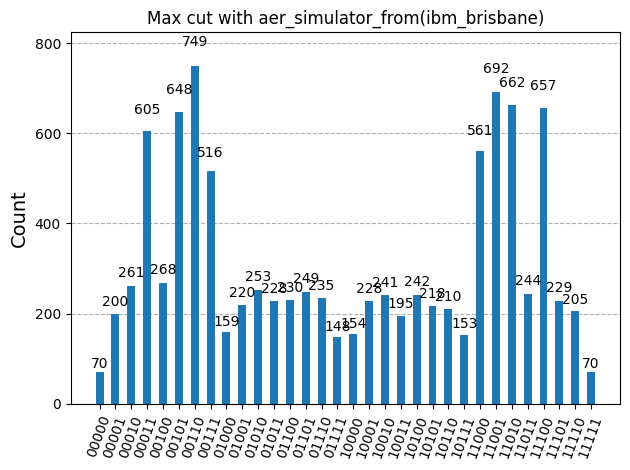

Probability of measuring a solution for is 0.509
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -2.086849131508685
       x: [-4.924e-01 -2.329e-01 -7.605e-01 -6.285e-01]
    nfev: 200
   maxcv: 0.0


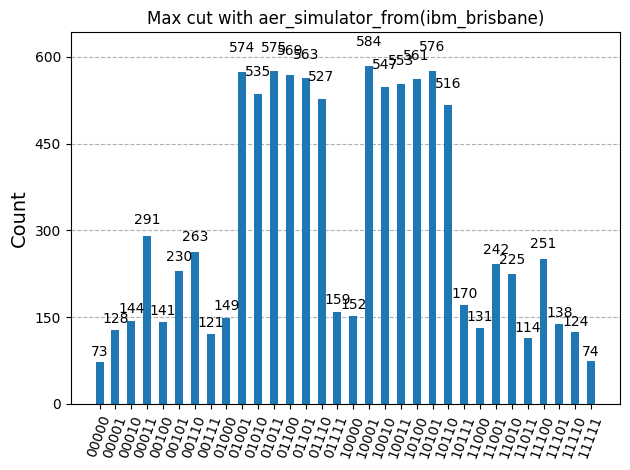

Probability of measuring a solution for is 0.1754


In [129]:
counts_list_transpiled_circuits = []
circuit_transpiled_list = [circuit_transpiled, circuit_opt_seed]
opt_params_list_transpiled_circuits = []
for circuit in circuit_transpiled_list:
    result_backend, _ = train_qaoa(init_params, circuit, cost_hamiltonian, noisy_fake_backend)
    opt_params = result_backend.x
    opt_params_list_transpiled_circuits.append(opt_params)
    counts_list_transpiled_circuit = sample_qaoa(opt_params, circuit, noisy_fake_backend)
    counts_list_transpiled_circuits.append(counts_list_transpiled_circuits)
    solutions_counts = [counts_list_transpiled_circuit[key] for key in states_solutions]
    print(f"Probability of measuring a solution for is {float(sum(solutions_counts)/SHOTS)}")

In the following, keep in mind to use `sabre` layout method and loop over different seeds to minimize a specific metric, such as two-qubit gate counts or depth or accumulated error, in order to maximize performance.

In this section we have seen that transpilation is a key step in preparing quantum circuits to be executed on real hardware. Since different devices have different layouts and gate sets, a good transpiler helps to adapt your circuit to fit the hardware while trying to keep things like quantum depth and error rates low, thus achieving better performance from your quantum algorithms.

# 5. Error Mitigation (EM) <a id="em"></a>

One of the main areas of research to address the inevitable noise in quantum devices is **error mitigation (EM)**. EM consists of a set of intelligent techniques designed to reduce the impact of noise without requiring complex error correction codes or additional qubits, resources that remain limited in today's quantum hardware. Instead of correcting errors as they occur, EM uses strategies such as loop repetition, calibration-based adjustments, and classical post-processing to improve the quality of the final results, leading to an improved performance in our quantum algorithms.

This approach is especially valuable for current devices, which are small to medium scale and inherently noisy. Fully fault-tolerant quantum computing is still beyond our reach, but EM offers a practical way to take full advantage of the devices we have now.
EM integrates naturally with hybrid quantum-classical algorithms, those that alternate between quantum and classical computation, such as:

- Variational Quantum Eigensolver (VQE),
- Quantum Approximate Optimization Algorithm (QAOA),
- Quantum-enhanced machine learning models.

These types of algorithms are especially sensitive to noise, and EM can greatly improve their reliability and accuracy.

Remarkably, EM does not eliminate all imperfections, but it refines the result enough to make it useful and actionable. For it is a tool for narrowing the gap between noisy quantum results and meaningful insights, paving the way for practical quantum applications even before large-scale error-correcting machines become a reality.

There are several well-established techniques used in Error Mitigation (EM), each tailored to address different types of noise and imperfections in quantum computations.

One of the most widely used methods is Zero Noise Extrapolation (ZNE). In this approach, the same quantum circuit is executed multiple times with deliberately increased noise levels. Then, mathematical extrapolation techniques are applied to estimate what the outcome would have been in the absence of noise. This method was introduced by [Temme et al. in 2017](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.180509).



## 5.1 Zero Noise Extrapolation (ZNE) <a id="zne"></a>

Is a powerful quantum error mitigation technique designed to reduce the impact of noise in quantum circuits without requiring additional qubits or full error correction. The process consists of three essential stages: noise amplification, execution at various noise levels, and classical extrapolation back to the zero-noise limit.


### Noise amplification

The first stage, Noise Amplification, lies at the heart of ZNE. The idea is to run the quantum circuit in versions that have more noise than usual, but in a controlled and reversible way. By comparing how the output changes as noise increases, it becomes possible to infer what the result would be with no noise at all. This is typically achieved using a technique called circuit folding.

Circuit folding artificially increases the noise in a quantum computation by inserting additional gates that, in theory, do not alter the logical outcome. These additional gates are the adjoint (inverse) operations of previously applied gates. For example, a unitary operation $U $ can be transformed into  $ U \cdot U^\dagger \cdot U$, which logically still computes $U$, but takes longer to execute, thus being exposed to more noise from the hardware.


There are two common types of folding: **Global Folding** and **Local Folding**. 


#### Global folding



In Global Folding, the entire quantum circuit is folded as a single block. This means the full unitary operation $U$ that the circuit represents is wrapped with its adjoint operation, yielding the transformation:

$$U \rightarrow U \cdot U^\dagger \cdot U$$

This global transformation is logically equivalent to the original circuit, since $U^\dagger \cdot U$ is the identity operation. However, because the circuit is now longer and includes more gate operations, it becomes more susceptible to environmental noise and hardware imperfections.

Global Folding is particularly useful for quickly applying a uniform increase in noise across the full circuit. It is straightforward to implement and does not require knowledge of the internal structure of the circuit. As such, it serves as a coarse-grained approach to noise amplification, suitable for general-purpose extrapolation when fine control is not needed.


<a id="exercise_6a"></a>

<div class="alert alert-block alert-success">
<b>Exercise 6a: Global Folding</b>

**Your Goal:** Implement global folding on the quantum circuits.

In this part of Exercise 6 (Section a), you will create a function that applies global folding to any quantum circuit. Your implementation should allow evaluation of the circuit at different noise scaling factors, which simulate increased noise levels while preserving the circuit's logical output. The noise scaling factor represents the number of times a circuit $U$ or $U^\dagger$ is applied, with 1 being the non-folding case.

</div>

In [130]:
def fold_global_circuit(circuit: QuantumCircuit, scale_factor: int) -> QuantumCircuit:
    """Apply global circuit folding for Zero Noise Extrapolation (ZNE)."""
    if scale_factor % 2 == 0 or scale_factor < 1:
        raise ValueError("scale_factor must be an odd positive integer (1, 3, 5, ...)")

    # number of extra U†·U blocks to insert
    n_repeat = (scale_factor - 1) // 2

    # prepare a fresh folded circuit with the same registers
    folded_circuit = QuantumCircuit(circuit.num_qubits, circuit.num_clbits)

    def remove_all_measurements(qc: QuantumCircuit) -> QuantumCircuit:
        """Remove all measurements from a quantum circuit."""
        clean_qc = QuantumCircuit(qc.num_qubits)
        for instr, qargs, _ in qc.data:
            if instr.name != "measure":
                clean_qc.append(instr, qargs)
        return clean_qc

    # strip out measurements so we only fold the unitary part
    clean_circuit = remove_all_measurements(circuit)

    # append U once
    folded_circuit.append(clean_circuit.to_instruction(), clean_circuit.qubits)

    # for each repetition, append U† then U
    inv_instr = clean_circuit.inverse().to_instruction()
    fwd_instr = clean_circuit.to_instruction()
    for _ in range(n_repeat):
        folded_circuit.append(inv_instr, clean_circuit.qubits)
        folded_circuit.append(fwd_instr, clean_circuit.qubits)

    # finally, re-append all the original measurements
    for instr, qargs, cargs in circuit.data:
        if instr.name == "measure":
            folded_circuit.append(instr, qargs, cargs)

    return folded_circuit

In [131]:
# Submit your answer using following code

grade_lab2_ex6a(fold_global_circuit)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


#### Local Folding


Local folding focuses on selectively increasing the noise in specific parts of the quantum circuit, usually around the most error-prone gates or subcircuits. Instead of folding the entire circuit as a block, this method focuses on individual quantum gates or groups of gates. This provides greater control and more precise calibration of the noise amplification process. Its operation being to take from the quantum circuit each quantum gate $G$, we can apply local folding by wrapping it with its inverse operation as follows:

$$ G \rightarrow G \cdot G^\dagger \cdot G $$

This transformation logically cancels the inserted $G^\dagger \cdot G$ pair, leaving the computation unchanged. However, the execution now involves three times as many gate operations, thereby increasing the local noise exposure. This makes it ideal for simulating different noise levels selectively and systematically.


<a id="exercise_6b"></a>

<div class="alert alert-block alert-success">
<b>Exercise 6b: Local Folding</b>


**Your Goal:** Implement local folding on the quantum circuits.

In this second part of Exercise 6 (Section b), your task is to write a function that applies local folding to a quantum circuit. Unlike global folding, this method focuses on individual gates and selectively folds them to amplify noise in specific areas of the circuit. The function should allow flexible control of the gates being folded and their evaluation at different noise amplification scales.

</div>

In [132]:
def fold_local_circuit(circuit: QuantumCircuit, scale_factor: int) -> QuantumCircuit:
    """Performs Zero-Noise Folding at the level of individual circuit instructions."""

    if scale_factor % 2 == 0 or scale_factor < 1:
        raise ValueError("scale_factor must be an odd positive integer (1, 3, 5, ...)")

    # number of times to insert the G†G pair
    n_repeat = (scale_factor - 1) // 2
    qc_folded = QuantumCircuit(circuit.num_qubits, circuit.num_clbits)

    # For each instruction in the original circuit...
    for instr, qargs, cargs in circuit.data:
        # Always re-append measurements unchanged
        if instr.name == "measure":
            qc_folded.append(instr, qargs, cargs)
            continue

        # Otherwise, for each gate G, append G then (G†·G) repeated n_repeat times
        # First, append the gate once
        qc_folded.append(instr, qargs, cargs)

        # Now insert the inverse+forward layers
        for _ in range(n_repeat):
            # G†
            inv = instr.inverse()
            qc_folded.append(inv, qargs, cargs)
            # G
            qc_folded.append(instr, qargs, cargs)

    return qc_folded

In [133]:
# Submit your answer using following code

grade_lab2_ex6b(fold_local_circuit)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Extrapolation


After amplifying the noise through folding, the quantum circuit is executed multiple times at different noise levels. Finally, in the third step, **Extrapolation**, the results from the noisy runs are post-processed using classical fitting methods, such as linear, polynomial, or exponential extrapolation, to estimate what the outcome would be in a hypothetical zero-noise scenario. Through this pipeline, ZNE helps recover higher-fidelity results from current noisy quantum hardware, making it a valuable tool in the near-term quantum computing landscape.

In [ ]:
def basic_zne(
    circuit: QuantumCircuit,
    scales: list[int],
    backend: QiskitRuntimeService.backend,
    opt_params: np.array,
    observable: SparsePauliOp,
) -> tuple[np.ndarray, list[float], tuple]:
    """Basic Zero Noise Extrapolation (ZNE) loop using local folding."""

    exp_vals = []
    xdata = np.array(scales)
    # Note that the pub variable has to include the quantum circuit, the observable and the parameters


    observable = cost_hamiltonian
    estimator = Estimator(mode=backend)

    for scale in scales:
        # Apply local folding
        folded = fold_local_circuit(circuit, scale)
        # Transpile for the backend
        basis_gates = backend.target.operation_names
        pub = (
            transpile(folded, basis_gates=basis_gates, optimization_level=0),
            observable,
            opt_params,
        )
        # Evaluate the expectation value
        job = estimator.run([pub])
        results = job.result()[0]
        exp_vals.append(results.data.evs)


    return xdata, exp_vals, pub

In [ ]:
scales = [1, 3, 5, 7, 9, 11, 13]
xdata, ydata, pub = basic_zne(
    qaoa_circuit_transpiled, scales, noisy_fake_backend, opt_params_list[num_backend], cost_hamiltonian
)

To validate and analyse the results of the Zero Noise Extrapolation (ZNE) we just implemented, we can apply three types of extrapolation methods: linear, polynomial, and exponential. These approaches help estimate the circuit's output in the zero-noise limit based on the data collected at higher noise levels. To illustrate how this can be done, consider the following example code:

In [ ]:
methods = ["linear", "quadratic", "exponential"]

for method in methods:
    print(f"\n Extrapolation Method: {method.upper()}")

    # Perform the extrapolation
    zero_val, fitted_vals, fit_params, fit_fn = zne_method(method=method, xdata=xdata, ydata=ydata)

    # Print the extrapolated expectation value
    print(f"⟨Z⟩ (ZNE Estimate): {zero_val:.3f}")

    # Plot the results
    plot_zne(xdata, fitted_vals, zero_val, fit_fn, fit_params, method)

# Conclusions <a id="conclusions"></a>

Good job completing Lab 2! 

In this Lab we explored the various sources of noise that can affect your quantum circuit and more importantly the dedicated tools we can use to *cut through the noise*. With these tools at hand you're now well-equipped to tackle any of your ongoing quantum algorithms and execute them on real quantum hardware. Remember, the key steps to follow are:

- **Choose the right hardware** that is well-suited for your circuit.
- **Use the transpiler** to select the best possible layout and minimize the number of two-qubit gates and other metrics.
- **Apply error mitigation and suppression** to further reduce the impact of noise and improve the performance.

Keep that in mind and you are all set to tackle your quantum challenges ahead!

That's all folks! Or it is not?

As a bonus, we've included an extra exercise below where you'll implement the Max-Cut problem on IBMQ hardware. This is your chance to put everything you've learned into practice, including the error mitigation techniques!

# Bonus challenge: Scaling it up! <a id="bonus"></a>

In this bonus exercise we'll tackle a more complicated version of this problem to test all the techniques we have learned with a real problem that can also be executed on hardware.

### The problem

In [ ]:
# We define the number of nodes:
n_ext = 7
# We define the graph
graph_ext = rx.PyGraph()
graph_ext.add_nodes_from(np.arange(0, n_ext, 1))
generic_backend_ext = GenericBackendV2(n_ext, seed=seed)
weights = 1
# We make it explicitly asymetrical to have a smaller set of solutions
graph_ext.add_edges_from(
    [(edge[0], edge[1], weights) for edge in generic_backend_ext.coupling_map][:-7]
)
draw_graph(graph_ext, node_size=200, with_labels=True, width=1)
max_cut_paulis_ext = graph_to_Pauli(graph_ext)
cost_hamiltonian_ext = SparsePauliOp.from_list(max_cut_paulis_ext)
pm = generate_preset_pass_manager(
    optimization_level=3, backend=generic_backend_ext, seed_transpiler=seed
)
layers = 2
init_params = np.zeros(2 * layers)
qaoa_circuit_ext = QAOAAnsatz(cost_operator=cost_hamiltonian_ext, reps=layers)
qaoa_circuit_ext.measure_all()
qaoa_circuit_ext_transpiled = pm.run(qaoa_circuit_ext)

### Choose the backend

In [ ]:
qaoa_circuit_transpiled_ext_list = []
acc_error_list = []


for backend_hw in real_backends:

    pm = generate_preset_pass_manager(
        optimization_level=3, backend=backend_hw, seed_transpiler=seed
    )
    qaoa_circuit_transpiled_ext = pm.run([qaoa_circuit_ext])[0]
    qaoa_circuit_transpiled_ext_list.append(qaoa_circuit_transpiled_ext)

    # ---- TODO : Bonus Task ---
    # Use the accumulated_errors function and get the [0] value
    acc_error = 



    # --- End of TODO ---

    acc_error_list.append(acc_error)
# We choose the backend with smallest error
best_backend_ext = real_backends[acc_error_list.index(min(acc_error_list))]
print(
    f"The backend {best_backend_ext.name} has the circuit with the smallest accumulated error: {min(acc_error_list):.3f}"
)

### We optimize the layout and minimize the accumulated error

In [ ]:
circuit_ext_opt_seed, best_seed_transpiler, min_err_acc_seed, _ = finding_best_seed(
    qaoa_circuit_ext, best_backend_ext
)
print(f"Best transpiler seed: {best_seed_transpiler}")
print(f"Minimum accumulated two-qubit gate error: {min_err_acc_seed:.3f}")

### We execute the circuit on simulator

First, we must optimize the parameters of this QAOA problem. 

In [ ]:
best_backend_sim = AerSimulator.from_backend(best_backend_ext, seed_simulator=seed)
result_qaoa_sim, objective_func_vals_sim = train_qaoa(
    init_params, circuit_ext_opt_seed, cost_hamiltonian_ext, best_backend_sim
)

Now we can sample from the QAOA circuit

In [ ]:
opt_params_sim = result_qaoa_sim.x
counts_list_sim = sample_qaoa(opt_params_sim, circuit_ext_opt_seed, best_backend_sim)

# Checking the results

In [ ]:
eigenvalues_ext, eigenvectors_ext = np.linalg.eig(cost_hamiltonian_ext)
ground_energy_ext = min(eigenvalues_ext).real
num_solutions_ext = eigenvalues_ext.tolist().count(ground_energy_ext)
index_solutions_ext = np.where(eigenvalues_ext == ground_energy_ext)[0].tolist()
print(f"The ground energy of the Hamiltonian is {ground_energy_ext}")
print(f"The number of solutions of the problem is {num_solutions_ext}")
print(f"The list of the solutions based on their index is {index_solutions_ext}")

states_solutions_ext = decimal_to_binary(index_solutions_ext, n_ext)
# Sort the dictionary items by their counts in descending order
sorted_states_sim = sorted(counts_list_sim.items(), key=lambda item: item[1], reverse=True)
# Take the top 'num_solutions' entries
top_states_sim = sorted_states_sim[:num_solutions_ext]
# Extract only the states keys from the top entries
qaoa_ground_states_sim = sorted([state for state, count in top_states_sim])
print(f"The analytical solutions for the Max-cut problem are: {states_solutions_ext}")
print(
    f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states_sim} for {best_backend_sim.name}"
)

# Running on Hardware


<a id="Warning_1"></a>

<div class="alert alert-block alert-warning">
  <b>Resource limit:</b> 

When running the section below, you will execute the above problem on real hardware possibly consuming approximately 2-3 minutes of the free plan. Please proceed only if you're comfortable with this potential usage. And pleasetry to maintain these settings if possible, to make sure you use not too much time. 
</div>

Finally we can execute the problem on hardware and compare the results that we obtain in this case.


### Estimator

We will not train the QAOA circuit on hardware, as it will consume a lot of your free time that you have for execution on IBM hardware. Instead, we'll execute the estimator with the optimized parameters and will apply error mitigation techniques later to see how we can improve the results.

First we compute the ground state energy on hardware without error mitigation

In [ ]:
# ---- TODO : Bonus Task ---

# Based on previous section, choose the best backend for executing the code on hardware
best_backend_hw = 

# --- End of TODO ---

options = EstimatorOptions(default_shots=100000)
estimator = Estimator(mode=best_backend_hw, options=options)
ground_energy_ext_hw = cost_func_estimator(
    opt_params_sim, circuit_ext_opt_seed, cost_hamiltonian_ext, estimator
)
print(
    f"The ground energy of the QAOA circuit executed on {best_backend_hw.name} without EM is: {ground_energy_ext_hw}"
)

Now we apply different error mitigation and error suppression techniques.
The different techniques we'll apply are:

- **Dynamical decoupling**: this error suppression technique involves applying a sequence of control pulses to idle qubits to cancel out unwanted interactions and coherent errors. It helps preserve quantum coherence by effectively "decoupling" the system from noise sources over time.
- **Pauli twirling**: this error mitigation technique transforms arbitrary noise into simpler Pauli noise by randomly applying and undoing Pauli gates around operations, reducing the impact of coherent errors and enabling more effective noise modeling and correction.
- **TREX**: Twirled Readout Error eXtinction is a readout error mitigation technique that reduces measurement errors by randomly flipping qubits before measurement and classically correcting the results, effectively diagonalizing the readout-error matrix and simplifying its inversion for more accurate expectation value estimation.
- **ZNE**: as explained before, ZNE is an error mitigation technique that estimates the result of a quantum computation as if it were run on a noise-free device. It does this by deliberately increasing the noise in a controlled way, measuring the results, and then extrapolating back to the zero-noise limit.

In [ ]:
options = EstimatorOptions(default_shots=100000)
# Dynamical Decoupling
options.dynamical_decoupling.enable = True

# Probabilistic Twirling
options.twirling.enable_gates = True
options.twirling.num_randomizations = 10
options.twirling.shots_per_randomization = 10000

# TREX
options.resilience.measure_mitigation = True
options.resilience.measure_noise_learning.num_randomizations = 10
options.resilience.measure_noise_learning.shots_per_randomization = 10000

# ZNE setup
options.resilience.zne_mitigation = True
options.resilience.zne.amplifier = "gate_folding"
options.resilience.zne.extrapolator = "polynomial_degree_2"
options.resilience.zne.noise_factors = (1, 3, 5)

# We execute on hardware
estimator_EM = Estimator(mode=best_backend_hw, options=options)
ground_energy_ext_hw_EM = cost_func_estimator(
    opt_params_sim, circuit_ext_opt_seed, cost_hamiltonian_ext, estimator_EM
)
print(
    f"The ground energy of the QAOA circuit executed on {best_backend_hw.name} with EM is: {ground_energy_ext_hw_EM}"
)

Now we can use the Sampler primitive on the real hardware without any error mitigation and suppression techniques.

In [ ]:
opt_params_sim = result_qaoa_sim.x
# We execute on hardware
sampler = Sampler(mode=best_backend_hw)
job = sampler.run([(circuit_ext_opt_seed, opt_params_sim)], shots=SHOTS)
results_sampler = job.result()
counts_list_hw = results_sampler[0].data.meas.get_counts()
display(plot_histogram(counts_list_hw, title=f"Max cut with {best_backend_hw.name} "))

Now we include error suppression techniques in the Sampler.

In [ ]:
opt_params_sim = result_qaoa_sim.x
# We execute on hardware
sampler = Sampler(mode=best_backend_hw)
# Set runtime options directly on the sampler
sampler.options.dynamical_decoupling.enable = True
job = sampler.run([(circuit_ext_opt_seed, opt_params_sim)], shots=SHOTS)
results_sampler = job.result()
counts_list_hw_EM = results_sampler[0].data.meas.get_counts()
display(plot_histogram(counts_list_hw_EM, title=f"Max cut with {best_backend_hw.name} with EM"))

### Check results

In [ ]:
sorted_states_hw = sorted(counts_list_hw.items(), key=lambda item: item[1], reverse=True)
top_states_hw = sorted_states_hw[:num_solutions_ext]
qaoa_ground_states_hw = sorted([state for state, count in top_states_hw])

sorted_states_hw_EM = sorted(counts_list_hw_EM.items(), key=lambda item: item[1], reverse=True)
top_states_hw_EM = sorted_states_hw_EM[:num_solutions_ext]
qaoa_ground_states_hw_EM = sorted([state for state, count in top_states_hw_EM])

print(f"The analytical solutions for the Max-cut problem are: {states_solutions_ext}")
print(
    f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states_hw} for {best_backend_hw.name}"
)
print(
    f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states_hw_EM} for {best_backend_hw.name} with EM"
)

Congratulations on reaching the end of the lab!
If you still have some time left for running experiments on hardware, feel free to explore a few additional things:

- Experiment with error mitigation techniques: try rerunning your execution on hardware using different error mitigation and suppression strategies. You can enable or disable specific techniques or tweak various parameters to study their impact.

- Redo the bonus challenge: try rerunning the entire bonus challenge section using a different backend to compare results and performance.

- Scale it more up: try scaling the problem to a larger system, such as 10 qubits, and rerun your experiments. However, this might take some time in both the simulator and hardware, so we encourage you to try the first two other points first.


# References:

[1] Fahri et al., "A Quantum Approximate Optimization Algorithm" (2014). [arXiv:quant-ph/1411.4028](https://arxiv.org/abs/1411.4028)

[2] Nation et al., "Suppressing Quantum Circuit Errors Due to System Variability" (2023). [PRX Quantum 4, 010327](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.4.010327)

[3] Temme et al., "Error Mitigation for Short-Depth Quantum Circuits" (2017).  [Phys. Rev. Lett. 119, 180509](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.180509)

# Additional information

**Created by:** Jorge Martínez de Lejarza, Alberto Maldonado

**Advised by:** Marcel Pfaffhauser, Paul Nation, Junye Huang

**Version:** 1.0
